# Trajectories Notebook: Processing, Synthesizing, Visualizing User Trajectories

While maintaining their privacy

In [22]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from evaluation.eval_util import *


# Define columns as variables
DEVICE_ID = 'device ID'
DWELLTIME = 'DwellTime'
TIMESTAMP = 'timestamp'

TRACT = 'TRACT'

Make the relabeled trajectory data file.

File format:

The file is delimited by spaces and newlines.  
There is one line per user trajectory.  We call this the 'stays trajectory vector'.
Each 'word' in the line is a label for a place (census tract) representing where
the user was at the given hour.  Sometimes there no place reported in which case the
value is null.

The vector is prefixed by labels for the user's inferred home (and work) place.

e.g. one line may look like:
1 2 0 1 1 1 1 1 1 1 0 2 2 2 2 0 3 2 2 4 1 1 .... 

Where 1 is the home label,  2 is the work label.
Sometimes we cannot infer a work place for a user, in which case the work label has a null/zero value.

The places people visit are relabeled with meaningless integers so that the trajectory vectors no longer disclose sensitive location data.
The relabeled trajectories are saved to file.  The mapping from real places to integer labels is also saved to file, but kept private so that the sensitive location information cannot be restored from an outsider.


In [23]:
# Open up real dwell data

# This is for 2 weeks of data starting on May 01 2018.
# startday = '2018-05-01'
# time_period_days = 14
# input_filepath = '../data/mount/201805/filtered/20180500_20180514/county_middlesex_norfolk_suffolk_7days_6nights.csv'
# relabeled_trajectories_filename = './data/relabeled_trajectories_2_weeks.txt'

# This is data for 1 work week May 7 - May 11
startday = '2018-05-07'
time_period_days = 5
input_filepath = '../data/mount/201805/filtered/20180507_20180511/county_middlesex_norfolk_suffolk_3days_3nights.csv'
relabeled_trajectories_filename = './data/relabeled_trajectories_1_workweek.txt'
# The label to int map is sensitive data.  It maps the real places to the privacy preserving integer labels.
# We save it to file, but it is not publicly commited.
# NOTE the naming convention (for gitignore): *label_to_int_map.json
label_to_int_map_filename = './data/relabeled_trajectories_1_workweek_label_to_int_map.json'

In [ ]:
df = pd.read_csv(input_filepath)

Note:
In the attach_areas processing, data points were removed that could not be placed in a tract (e.g. they were in the water).  For some users (1 for the 1-week data), this leaves them with an insufficient number of datapoints.

These users are removed.

In [26]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from trajectory_transformers import dwells_to_trajectory_vector, to_int_vocab, get_trajectory_home_label, get_trajectory_work_label


# Make the trajectory vectors for each user
users = df[DEVICE_ID].unique()
print('making trajectory vectors for %s users' % len(users))

# Map users to their dwell records
dwell_vectors = [] # A list of dwell vectors (which are themselves lists)
# Collect bad user dwell records
bad_dwell_records = []


def get_user_dwell_records(user_id, df):
    return df[df[DEVICE_ID] == user_id][[TIMESTAMP, DWELLTIME, TRACT]].to_dict('records')


for i, user_id in enumerate(users):
    if (i % 1000) == 0:
        print('creating dwell vector for user %s/%s' % (i, len(users)))
    user_dwell_records = get_user_dwell_records(user_id, df)
    dwell_vector = dwells_to_trajectory_vector(user_dwell_records, time_period_days=time_period_days, startday=startday)
    home_prefix = get_trajectory_home_label(dwell_vector)
    if (home_prefix == 0) or (home_prefix is None):
        print('skipping bad dwell vector for user %s with records' % user_id, user_dwell_records)
        bad_dwell_records.append(user_dwell_records)
        continue
    dwell_vectors.append(dwell_vector)

    
# Re-label the places in the trajectory vectors (i.e. a census tract is replaced by some other integer).
# Get back the {label -> int mapping} to store for later remapping back to tract labels
relabeled_dwell_vectors, label_to_int_dict = to_int_vocab(dwell_vectors)

# Prefix each trajectory vector by home,work labels
prefixed_dwell_vectors = []
for dwell_vector in relabeled_dwell_vectors:
    home_label = get_trajectory_home_label(dwell_vector)
    assert(home_label > 0)
    work_label = get_trajectory_work_label(dwell_vector)
    prefixed_dwell_vector = [home_label, work_label] + dwell_vector
    prefixed_dwell_vectors.append(prefixed_dwell_vector)


making trajectory vectors for 22705 users
creating dwell vector for user 0/22705
creating dwell vector for user 1000/22705
creating dwell vector for user 2000/22705
creating dwell vector for user 3000/22705
creating dwell vector for user 4000/22705
creating dwell vector for user 5000/22705
creating dwell vector for user 6000/22705
creating dwell vector for user 7000/22705
creating dwell vector for user 8000/22705
creating dwell vector for user 9000/22705
creating dwell vector for user 10000/22705
creating dwell vector for user 11000/22705
creating dwell vector for user 12000/22705
creating dwell vector for user 13000/22705
creating dwell vector for user 14000/22705
creating dwell vector for user 15000/22705
creating dwell vector for user 16000/22705
creating dwell vector for user 17000/22705
creating dwell vector for user 18000/22705
creating dwell vector for user 19000/22705
creating dwell vector for user 20000/22705
creating dwell vector for user 21000/22705
creating dwell vector for

In [27]:
# Save the output to file
# Each trajectory is one line
assert(len(prefixed_dwell_vectors[0]) == (24*time_period_days + 2))
print('a trajectory vector has %s elements' % len(prefixed_dwell_vectors[0]))

with open(relabeled_trajectories_filename, 'w+') as f:
    for vector in prefixed_dwell_vectors:
        vector_line = " ".join([str(w) for w in vector])
        f.write("%s\n" % vector_line)
    
print('wrote %s trajectory vectors to %s' % (len(prefixed_dwell_vectors), relabeled_trajectories_filename))

a trajectory vector has 122 elements
wrote 22704 trajectory vectors to ./data/relabeled_trajectories_1_workweek.txt


In [30]:
# Save the {label -> int} mapping so that we can restore the original labels later.
with open(label_to_int_map_filename, 'w') as f:
    json.dump(label_to_int_dict , f) 
print('wrote {label -> int} mapping to file: %s' % label_to_int_map_filename)

wrote {label -> int} mapping to file: ./data/relabeled_trajectories_1_workweek_label_to_int_map.json


In [17]:
# This is how you relabel the vectors with the original labels
label_to_int_map = None

with open(label_to_int_map_filename) as json_file:
    label_to_int_map = json.load(json_file)

label_to_int_map[None] = label_to_int_map['null']
del label_to_int_map['null']

int_to_label_map = {i:label for label, i in label_to_int_map.items()}
assert(len(int_to_label_map) == len(label_to_int_map))

# int_to_label_map
# label_to_int_map

## Sample from real population --> Generate synthetic data

The trained model generates synthetic trajectories where the (home, work) label pairs are
used as prefixes to produce the remainder of the trajectory.

We take a random sample of these (home, work) pairs from the real data for which to generate synthetic trajectories.  Note: This is the same as taking a random sample of user trajectories from the real data and then extracting the (home, work) pairs for each sample.

The generated synthetic trajectories are later evaluated against the full real dataset.

Sample size: 2000 (~10% of population)


### Home Work Labels to Counts

To do this, we generate a mapping of {(home, work) label pair --> count} where count is the number of occurances of that (home, work) label pair the real data set.

This makes the generation of synthetic populations more efficient.

In [78]:
# For full population
trajectories_prefixes_to_counts_filename = './data/relabeled_trajectories_1_workweek_prefixes_to_counts.json'

# For randomly sampled population
random_sample_size = 2000
# A random sample of trajectories is cut and used for synthetic generation, and saved to file
relabeled_trajectories_sample_2000_filename = './data/relabeled_trajectories_1_workweek_sample_2000.txt'
trajectories_prefixes_to_counts_sample_2000_filename = './data/relabeled_trajectories_1_workweek_prefixes_to_counts_sample_2000.json'


Script re-entry point: Skip next cell if the above cells were run

In [17]:
# Reading in prefixed dwell vectors in case this is a return to this script from here
prefixed_dwell_vectors = []
with open(relabeled_trajectories_filename, 'r') as f:
    for _i, line in enumerate(f):
        line = line.strip().split()
        prefixed_dwell_vectors.append([int(x) for x in line])

Make a mapping of {'home work': count for each label pair} and save it to file

In [29]:
def get_prefixes_to_counts_dict(prefixed_vectors):
    home_work_labels = []
    for v in prefixed_vectors:
        home_label = v[0]
        work_label = v[1]
        home_work_labels.append('%s %s' % (home_label, work_label))
    # Make a mapping of {'home work': count for each label pair}
    prefixes_to_counts_dict = {label_pair:0 for label_pair in home_work_labels}
    for label_pair in home_work_labels:
        prefixes_to_counts_dict[label_pair] += 1
    return prefixes_to_counts_dict

#### For full population:

In [27]:
prefixes_to_counts_dict = get_prefixes_to_counts_dict(prefixed_dwell_vectors)
prefixes_to_counts_dict

{'1 1': 27,
 '7 7': 41,
 '10 12': 1,
 '19 19': 15,
 '23 24': 1,
 '27 27': 25,
 '29 29': 11,
 '37 38': 1,
 '41 41': 26,
 '43 43': 27,
 '45 45': 42,
 '49 49': 11,
 '60 0': 2,
 '64 65': 1,
 '70 71': 3,
 '15 73': 1,
 '75 75': 12,
 '78 31': 1,
 '87 87': 83,
 '93 94': 1,
 '96 76': 1,
 '102 102': 33,
 '44 44': 94,
 '110 110': 14,
 '113 114': 1,
 '116 116': 51,
 '117 117': 27,
 '124 24': 2,
 '124 124': 27,
 '128 22': 1,
 '84 84': 51,
 '131 131': 13,
 '135 135': 19,
 '140 140': 35,
 '112 112': 28,
 '145 0': 1,
 '87 146': 1,
 '148 150': 2,
 '151 130': 2,
 '154 154': 13,
 '158 24': 1,
 '164 164': 21,
 '21 21': 148,
 '173 173': 18,
 '175 148': 1,
 '39 182': 2,
 '183 184': 3,
 '142 185': 1,
 '188 190': 1,
 '192 192': 25,
 '194 194': 25,
 '31 20': 2,
 '88 88': 36,
 '200 200': 37,
 '201 201': 14,
 '103 94': 4,
 '207 21': 3,
 '122 122': 47,
 '86 87': 1,
 '213 213': 10,
 '217 218': 1,
 '224 224': 22,
 '226 0': 3,
 '62 229': 1,
 '230 230': 28,
 '235 184': 1,
 '48 126': 1,
 '8 0': 9,
 '24 0': 9,
 '259 25

In [28]:
with open(trajectories_prefixes_to_counts_filename, 'w') as f:
    json.dump(prefixes_to_counts_dict , f) 
print("wrote {'home work': count} mapping to file: %s" % trajectories_prefixes_to_counts_filename)

wrote {'home work': count} mapping to file: ./data/relabeled_trajectories_1_workweek_prefixes_to_counts.json


Can then read in this mapping for the generator model like:

In [79]:
prefixes_to_counts_dict = None

with open(trajectories_prefixes_to_counts_filename) as json_file:
    prefixes_to_counts_dict = json.load(json_file)

prefixes_to_counts_dict

{'1 1': 27,
 '7 7': 41,
 '10 12': 1,
 '19 19': 15,
 '23 24': 1,
 '27 27': 25,
 '29 29': 11,
 '37 38': 1,
 '41 41': 26,
 '43 43': 27,
 '45 45': 42,
 '49 49': 11,
 '60 0': 2,
 '64 65': 1,
 '70 71': 3,
 '15 73': 1,
 '75 75': 12,
 '78 31': 1,
 '87 87': 83,
 '93 94': 1,
 '96 76': 1,
 '102 102': 33,
 '44 44': 94,
 '110 110': 14,
 '113 114': 1,
 '116 116': 51,
 '117 117': 27,
 '124 24': 2,
 '124 124': 27,
 '128 22': 1,
 '84 84': 51,
 '131 131': 13,
 '135 135': 19,
 '140 140': 35,
 '112 112': 28,
 '145 0': 1,
 '87 146': 1,
 '148 150': 2,
 '151 130': 2,
 '154 154': 13,
 '158 24': 1,
 '164 164': 21,
 '21 21': 148,
 '173 173': 18,
 '175 148': 1,
 '39 182': 2,
 '183 184': 3,
 '142 185': 1,
 '188 190': 1,
 '192 192': 25,
 '194 194': 25,
 '31 20': 2,
 '88 88': 36,
 '200 200': 37,
 '201 201': 14,
 '103 94': 4,
 '207 21': 3,
 '122 122': 47,
 '86 87': 1,
 '213 213': 10,
 '217 218': 1,
 '224 224': 22,
 '226 0': 3,
 '62 229': 1,
 '230 230': 28,
 '235 184': 1,
 '48 126': 1,
 '8 0': 9,
 '24 0': 9,
 '259 25

Understand the distribution of prefix labels to counts for full population

In [51]:
# Put this dictionary in DF to get the distribution of counts

def get_prefixes_to_counts_df(prefixes_to_counts_dict):
    return pd.DataFrame.from_dict({
        'prefix': [prefix for prefix in prefixes_to_counts_dict.keys()],
        'count': [count for count in prefixes_to_counts_dict.values()]})

prefixes_to_counts_df = get_prefixes_to_counts_df(prefixes_to_counts_dict)
prefixes_to_counts_df['count'].describe()

count    8659.000000
mean        2.622012
std         6.216765
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       148.000000
Name: count, dtype: float64

#### For sample population:

- Cut a sample population to generate synthetic trajectory data for
- Check sample distribution of home, work label pairs correlates with full population data
- Make a mapping of {'home work': count for each label pair} and save it to file

In [73]:
np.random.shuffle(prefixed_dwell_vectors)
prefixed_dwell_vectors_sample = prefixed_dwell_vectors[:random_sample_size]

In [74]:
prefixes_to_counts_sample_dict = get_prefixes_to_counts_dict(prefixed_dwell_vectors_sample)
prefixes_to_counts_sample_df = get_prefixes_to_counts_df(prefixes_to_counts_sample_dict)
prefixes_to_counts_sample_df.describe()

,count
count,1357.000000
mean,1.473839
std,1.137430
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,15.000000


In [75]:
prefixes_to_counts_df.set_index('prefix')['count'].corr(prefixes_to_counts_sample_df.set_index('prefix')['count'])

0.8025713989676533

Save sample to file
- saved sampled vectors to file
- save {home, work prefixes -> count} map to file

In [76]:
# Save the sample to file
# Each trajectory is one line
assert(len(prefixed_dwell_vectors_sample[0]) == (24*time_period_days + 2))
print('a trajectory vector has %s elements' % len(prefixed_dwell_vectors_sample[0]))

with open(relabeled_trajectories_sample_2000_filename, 'w+') as f:
    for vector in prefixed_dwell_vectors_sample:
        vector_line = " ".join([str(w) for w in vector])
        f.write("%s\n" % vector_line)
    
print('wrote %s trajectory vectors to %s' % (len(prefixed_dwell_vectors_sample), relabeled_trajectories_sample_2000_filename))

a trajectory vector has 122 elements
wrote 2000 trajectory vectors to ./data/relabeled_trajectories_1_workweek_sample_2000.txt


In [77]:
with open(trajectories_prefixes_to_counts_sample_2000_filename, 'w') as f:
    json.dump(prefixes_to_counts_sample_dict , f) 
print("wrote {'home work': count} mapping to file: %s" % trajectories_prefixes_to_counts_sample_2000_filename)

wrote {'home work': count} mapping to file: ./data/relabeled_trajectories_1_workweek_prefixes_to_counts_sample_2000.json


###  Cambridge Specific: Home Work Labels to Counts

Create a mapping of (home, work) -> count filtered to only users where the home label is a census tract located in Cambridge.

In [21]:
cambridge_census_tract_geoids = ['25017354900', '25017354800', '25017354700', '25017354600', '25017354500', '25017354400', '25017354300', '25017354200', '25017354100', '25017354000', '25017353900', '25017353800', '25017353700', '25017353600', '25017353500', '25017353400', '25017353300', '25017353200', '25017352102', '25017353102', '25017352101', '25017353000', '25017352900', '25017352800', '25017352700', '25017352600', '25017352500', '25017352400', '25017352300', '25017352200', '25017353101', '25017355000']

cambridge_trajectories_prefixes_to_counts_filename = './data/relabeled_cambridge_trajectories_1_workweek_prefixes_to_counts.json'

In [28]:
# Filter the prefixes_to_counts_dict to just (home, work) labels where the home label is within cambridge

cambridge_prefixes_to_counts_dict = {}
for prefix, count in prefixes_to_counts_dict.items():
    [home, work] = prefix.split()
    home_geoid = int_to_label_map[int(home)]
    if home_geoid in cambridge_census_tract_geoids:
        cambridge_prefixes_to_counts_dict[prefix] = count

cambridge_prefixes_to_counts_dict

{'183 184': 3,
 '183 183': 17,
 '277 278': 1,
 '302 0': 4,
 '171 171': 13,
 '480 184': 7,
 '290 97': 1,
 '519 127': 1,
 '290 290': 5,
 '556 387': 1,
 '56 76': 3,
 '97 97': 19,
 '447 447': 6,
 '56 56': 10,
 '558 558': 27,
 '603 603': 7,
 '480 183': 1,
 '290 204': 1,
 '302 185': 1,
 '552 5': 1,
 '558 0': 6,
 '386 150': 1,
 '269 269': 7,
 '519 519': 5,
 '386 386': 23,
 '184 184': 40,
 '183 626': 1,
 '552 143': 1,
 '57 57': 7,
 '269 0': 2,
 '56 284': 1,
 '644 644': 3,
 '450 450': 13,
 '573 100': 1,
 '386 501': 1,
 '552 69': 2,
 '556 556': 2,
 '480 480': 13,
 '558 373': 1,
 '369 388': 1,
 '184 221': 1,
 '558 98': 1,
 '573 459': 1,
 '56 450': 1,
 '279 279': 2,
 '76 76': 20,
 '97 0': 2,
 '183 333': 1,
 '183 645': 1,
 '386 76': 2,
 '573 573': 9,
 '369 369': 10,
 '76 22': 1,
 '326 326': 11,
 '277 119': 1,
 '274 274': 7,
 '56 21': 1,
 '373 373': 14,
 '552 552': 4,
 '76 84': 1,
 '76 184': 3,
 '447 0': 1,
 '386 69': 1,
 '184 0': 5,
 '290 340': 1,
 '558 119': 2,
 '277 277': 5,
 '76 0': 2,
 '76 32':

In [29]:
# Save to file
with open(cambridge_trajectories_prefixes_to_counts_filename, 'w') as f:
    json.dump(cambridge_prefixes_to_counts_dict , f) 
print("wrote cambridge specific {'home work': count} mapping to file: %s" % cambridge_trajectories_prefixes_to_counts_filename)

wrote cambridge specific {'home work': count} mapping to file: ./data/relabeled_cambridge_trajectories_1_workweek_prefixes_to_counts.json


# Trajectory Visualizations

Visualizing user trajectories (while maintaining their privacy)


In [33]:
relabeled_prefixed_dwell_vectors_subset = prefixed_dwell_vectors[:100]
for v in relabeled_prefixed_dwell_vectors_subset:
    print_dwell_vector_by_days(v)

----- vector ----
prefix labels:  [1, 1]
[1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
----- vector ----
prefix labels:  [7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 7, 7]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0]
[0, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7]
[7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 7, 9, 0, 7, 7, 0, 0]
----- vector ----
prefix labels:  [10, 12]
[10, 11, 11, 11, 11, 11, 12, 12, 12, 13, 12, 12, 0, 12, 12, 11, 11, 11, 14, 14, 14, 14, 14, 14]
[14, 14, 14, 14, 11, 11, 0, 12, 12, 12, 12, 12, 1

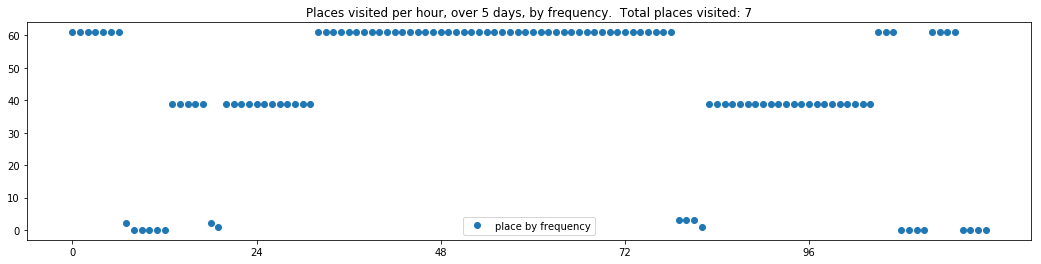

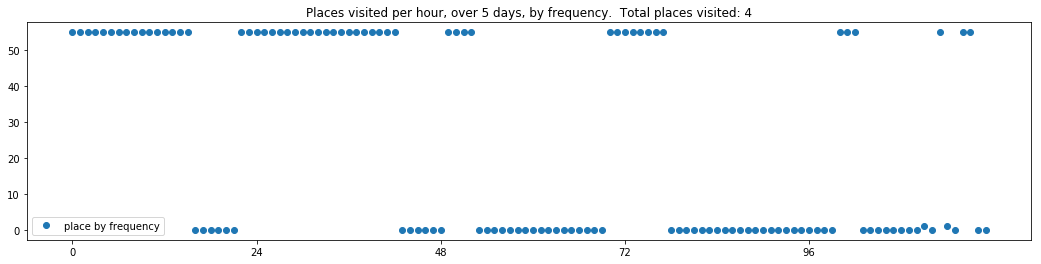

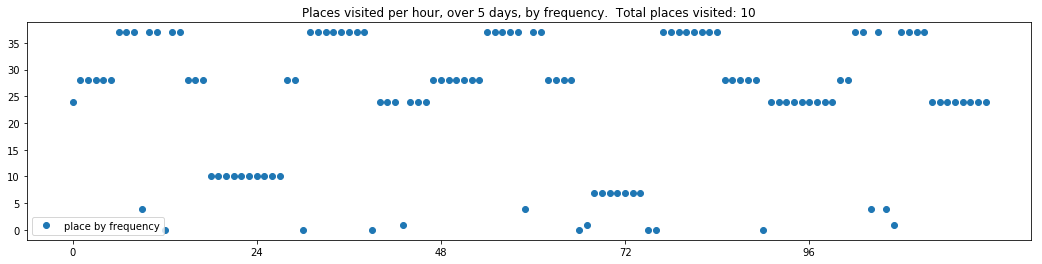

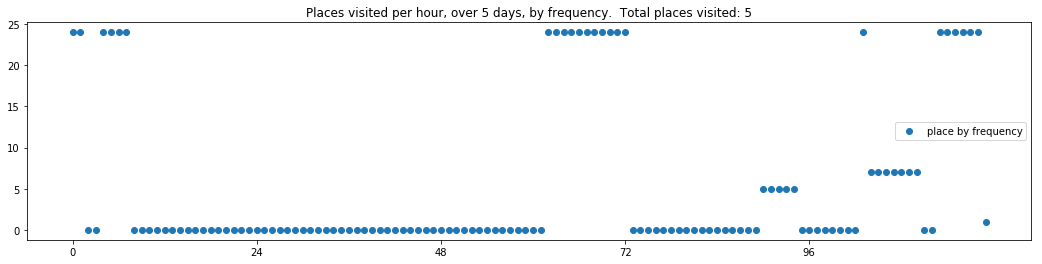

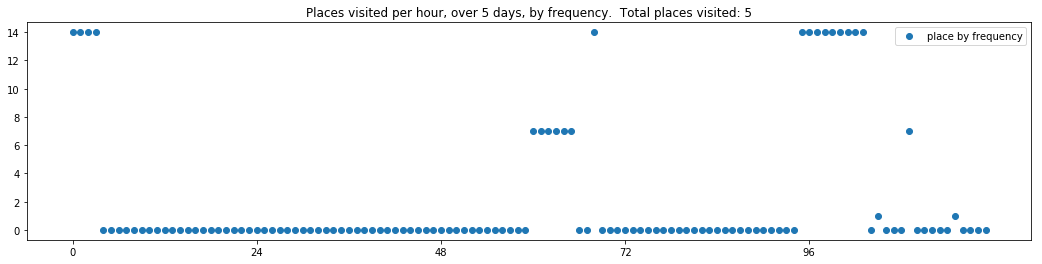

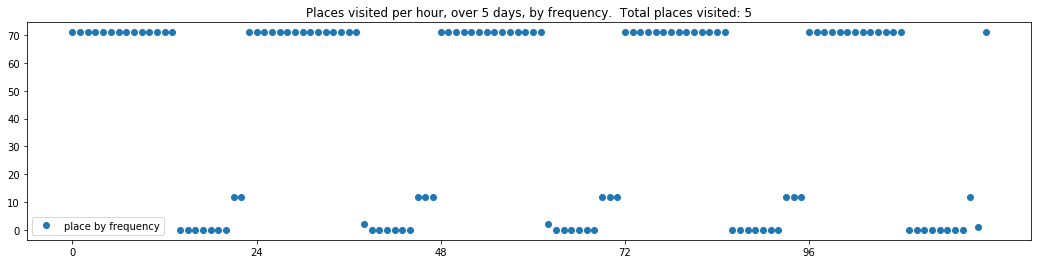

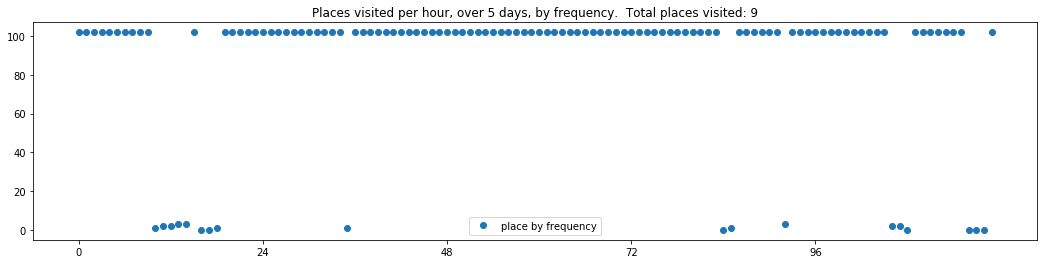

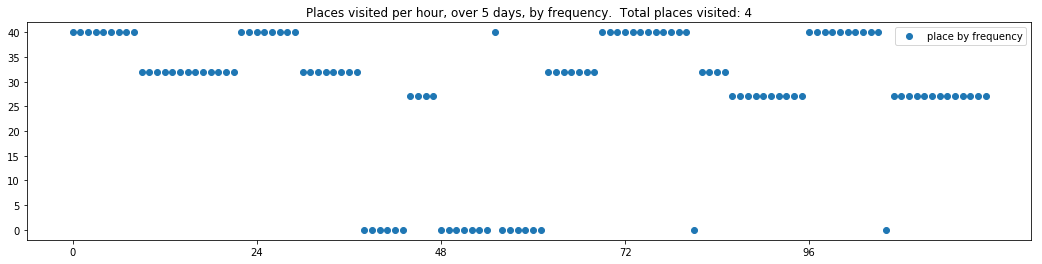

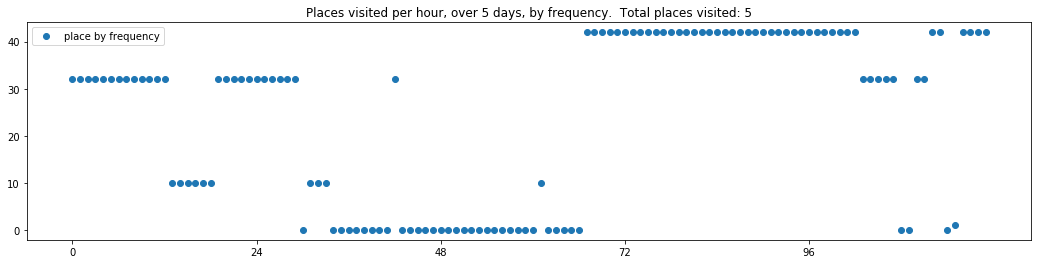

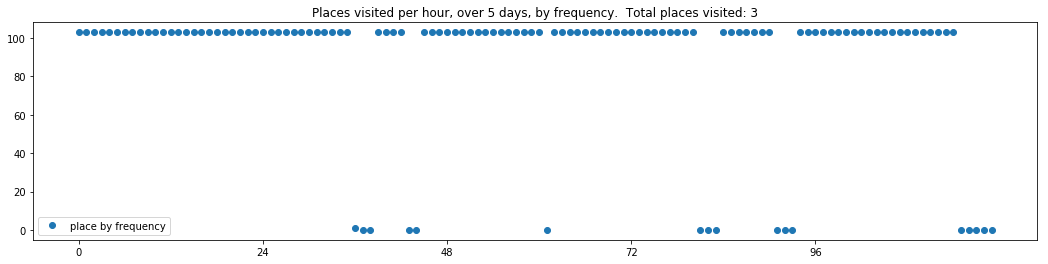

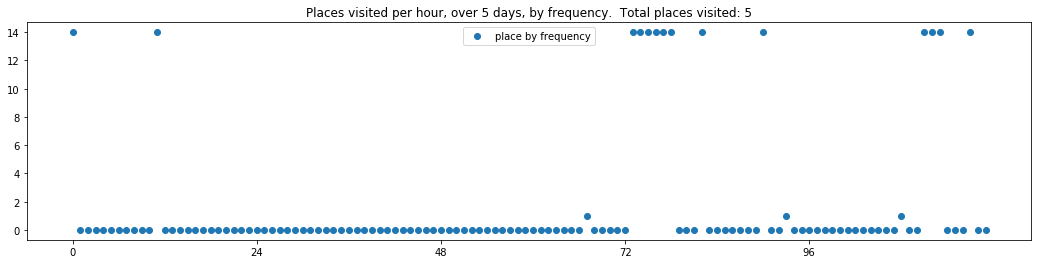

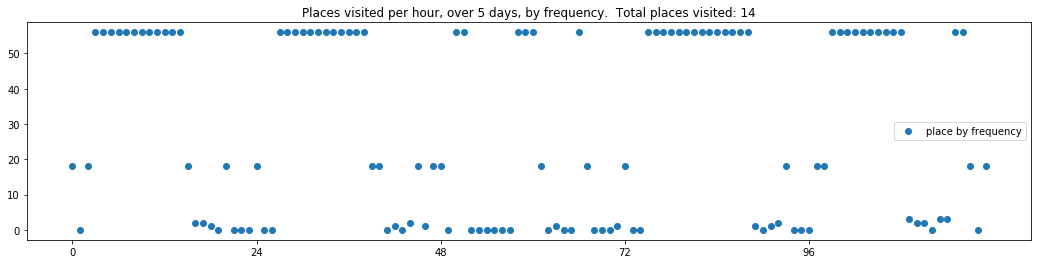

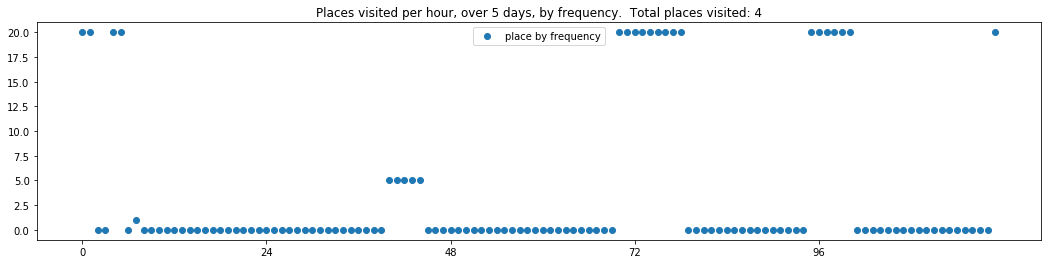

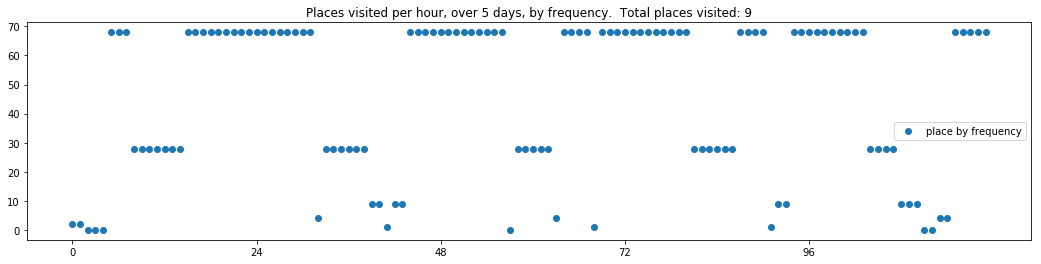

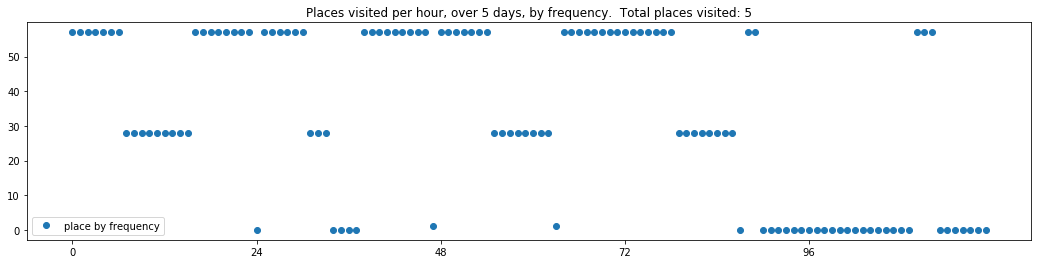

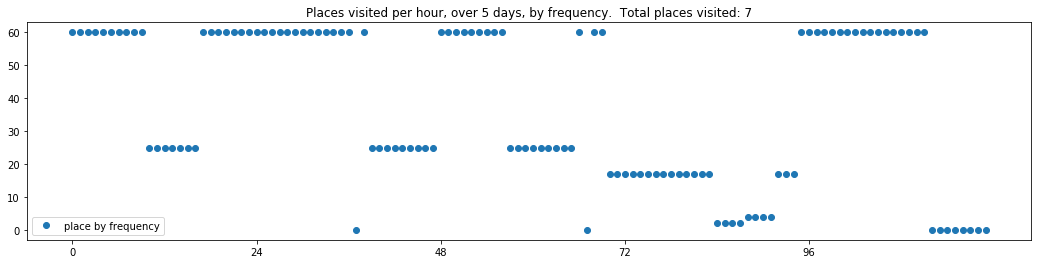

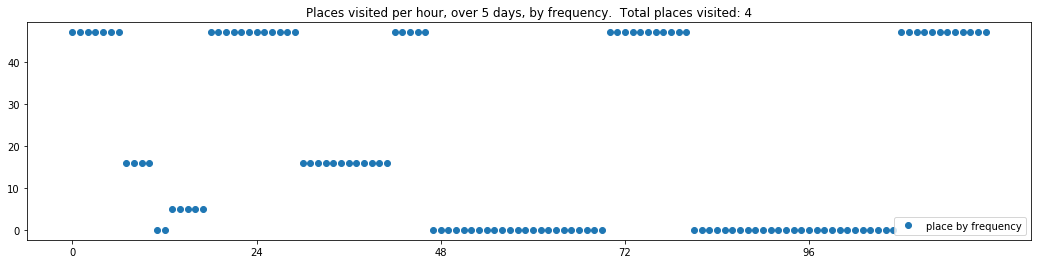

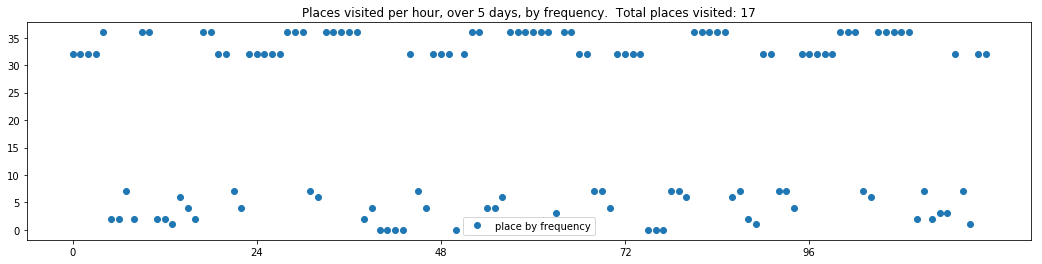

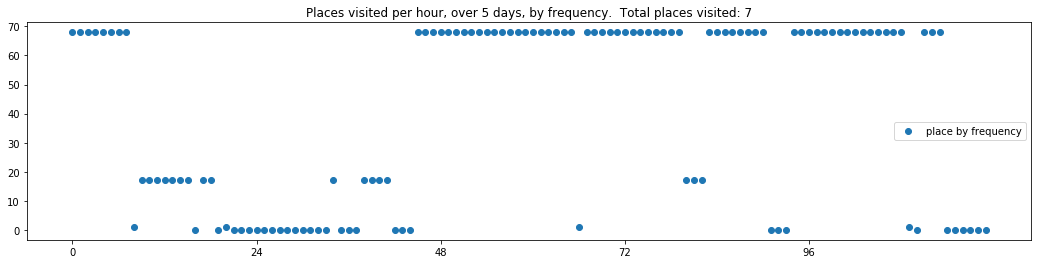

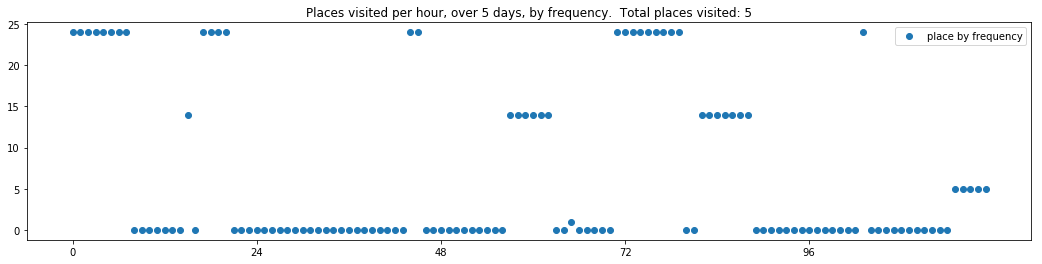

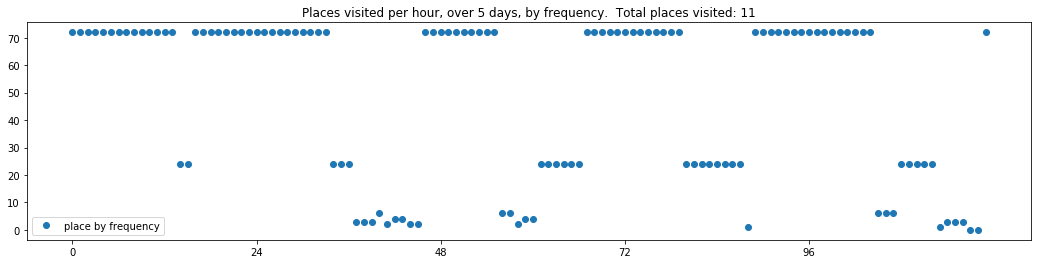

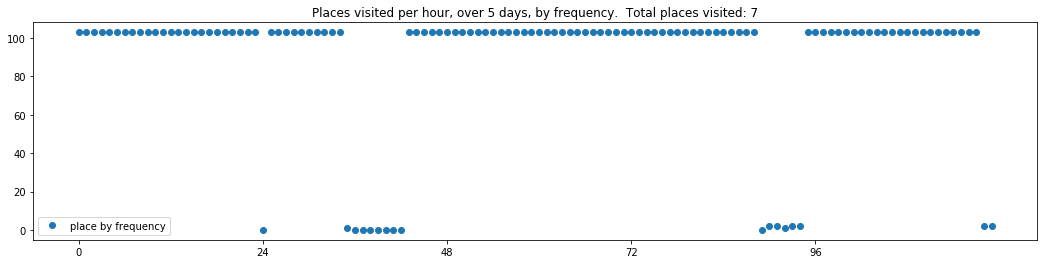

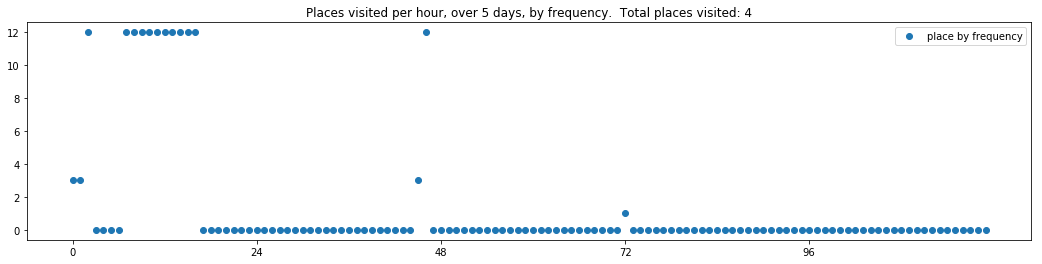

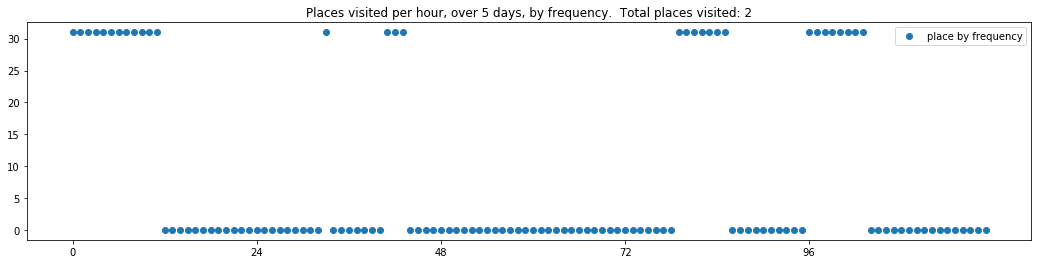

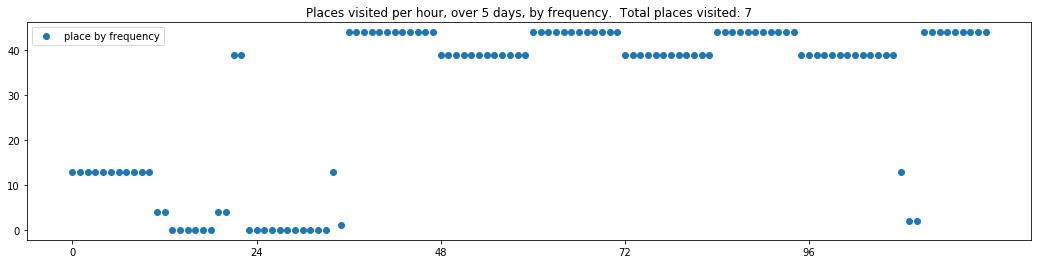

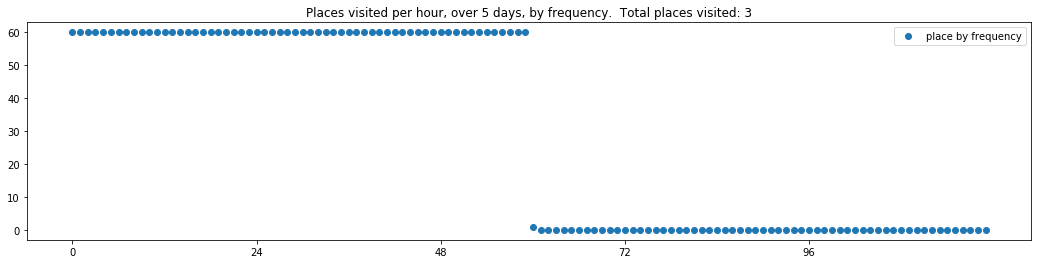

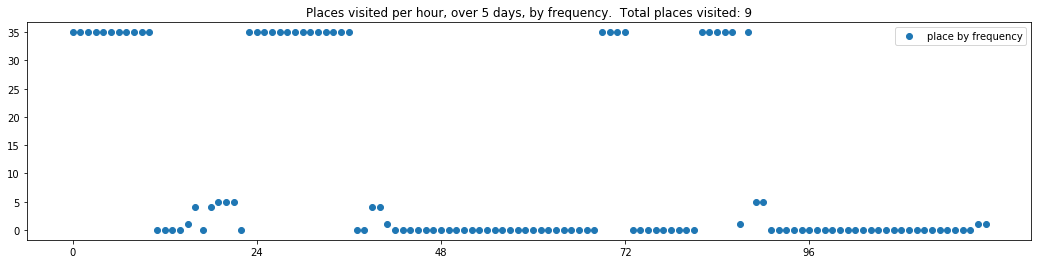

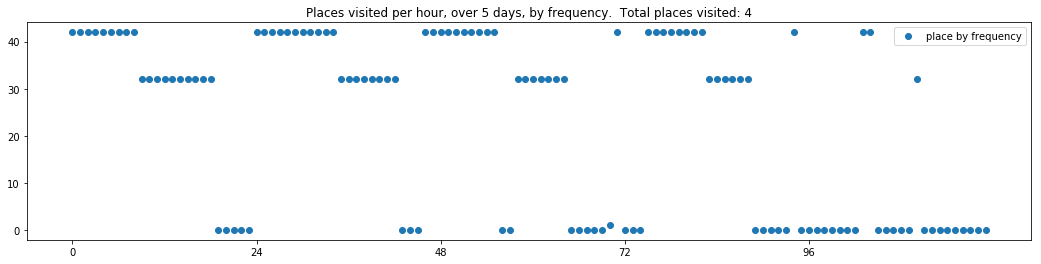

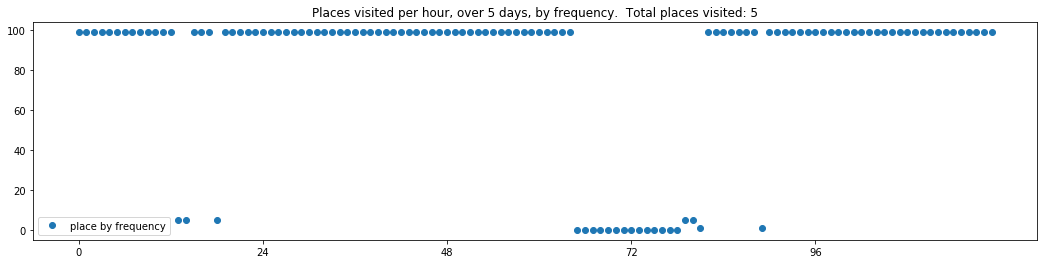

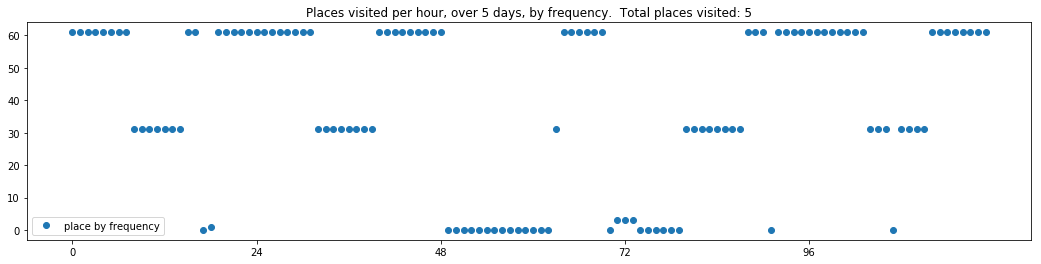

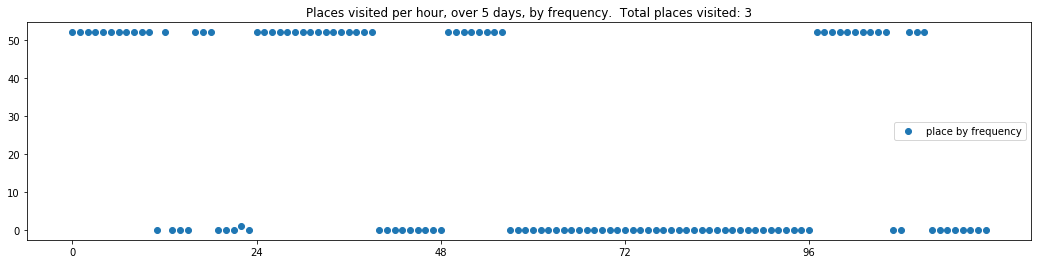

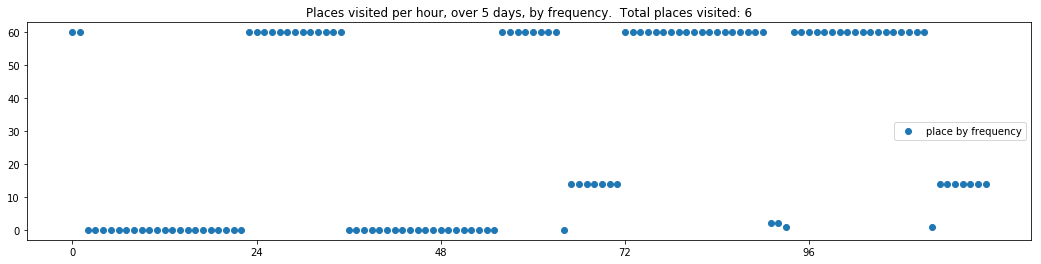

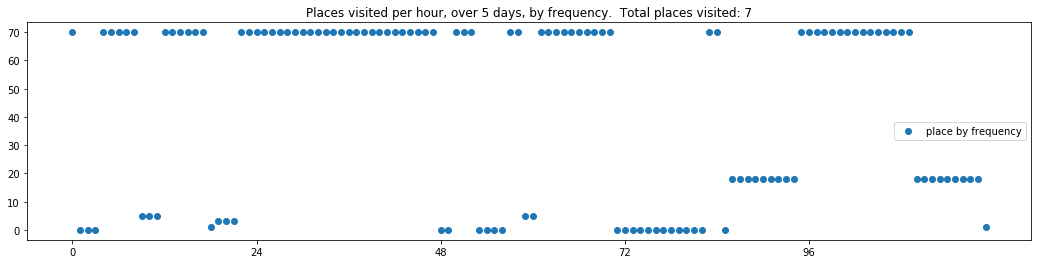

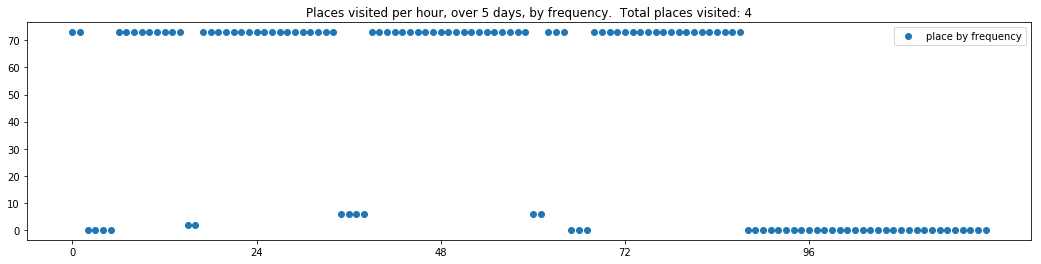

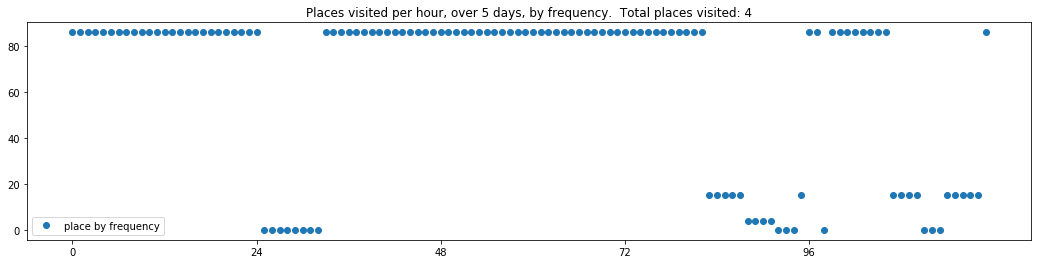

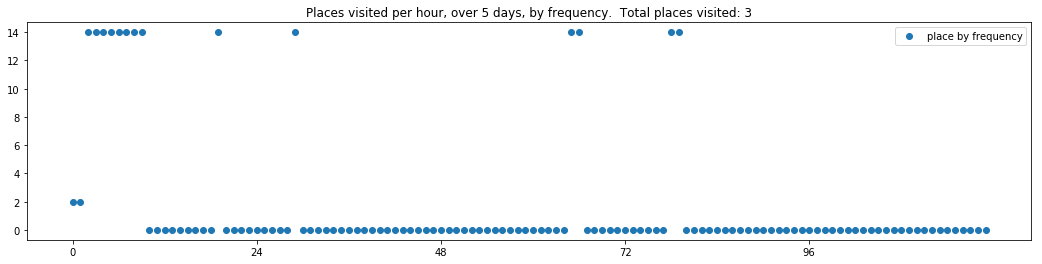

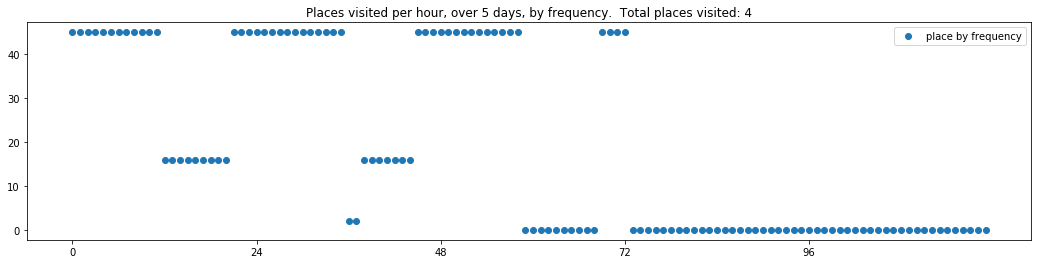

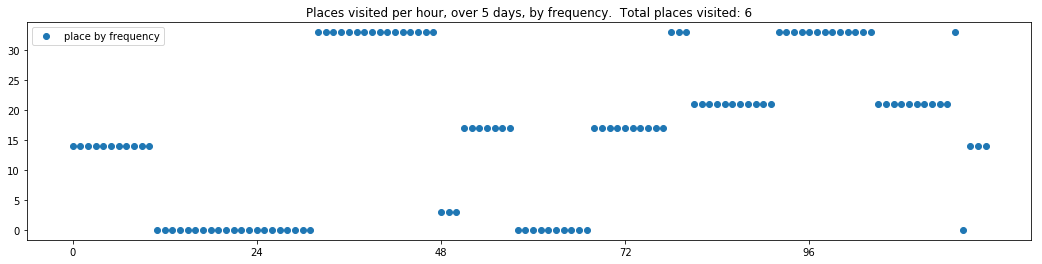

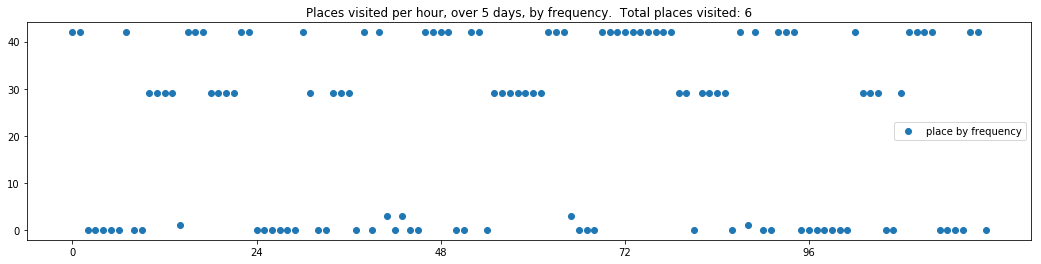

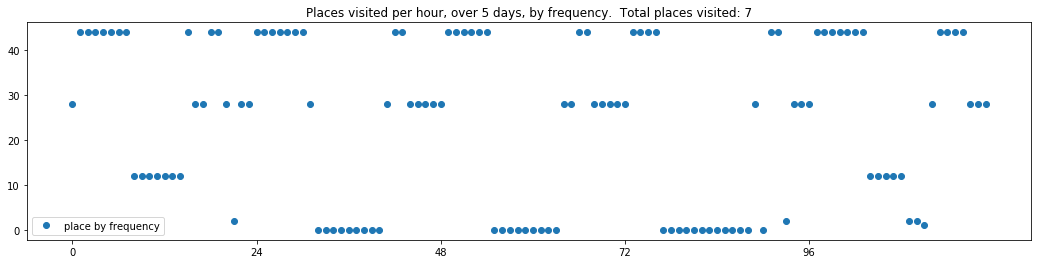

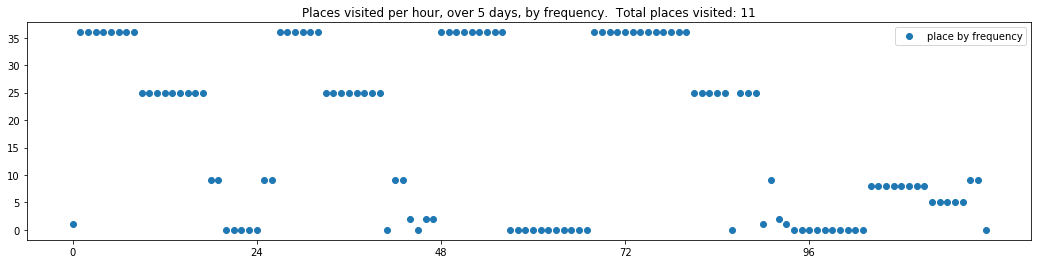

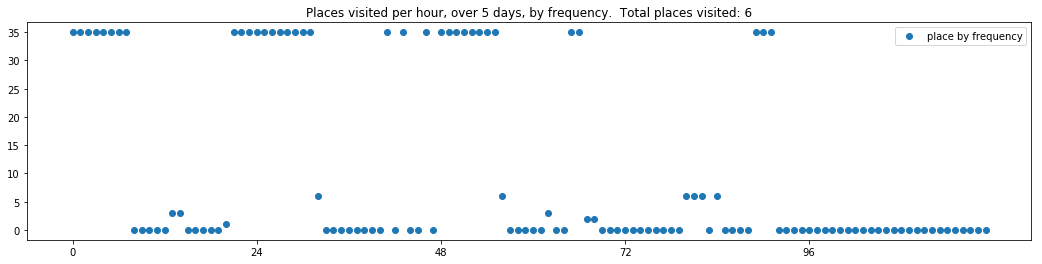

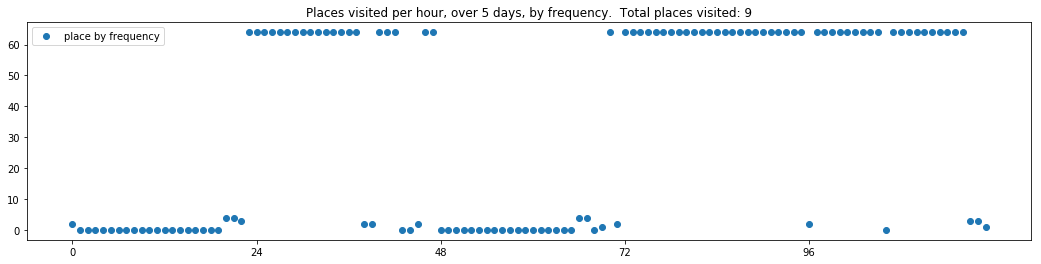

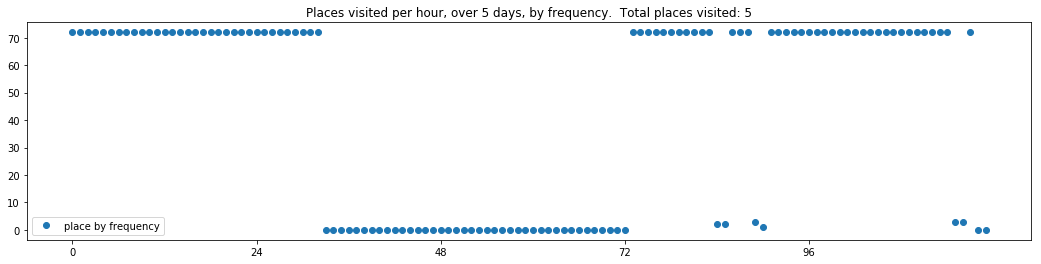

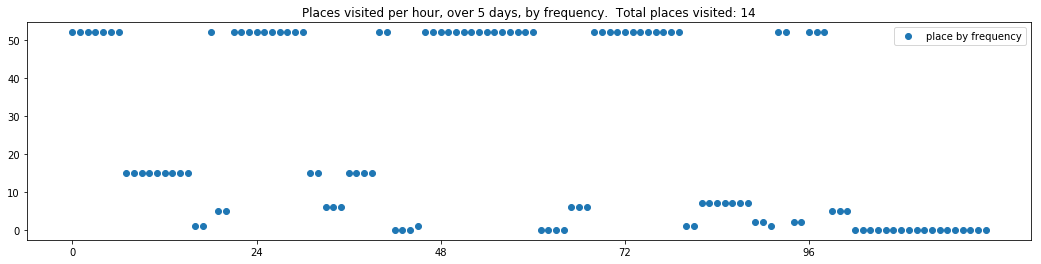

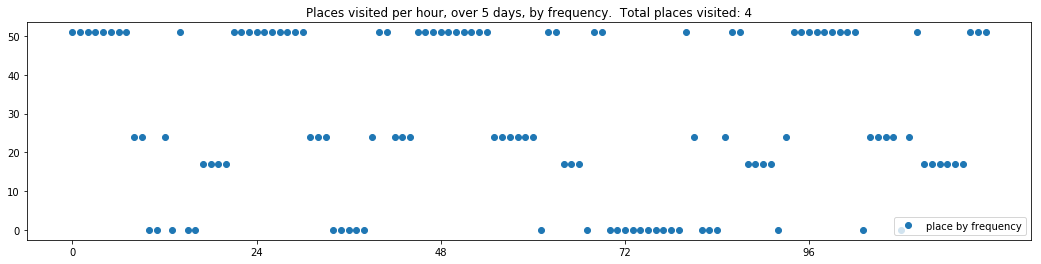

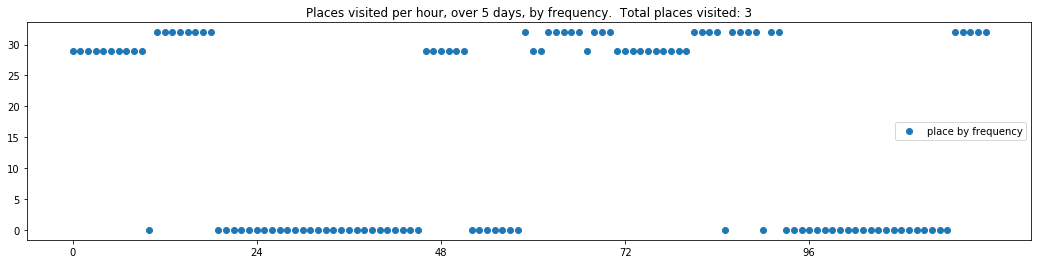

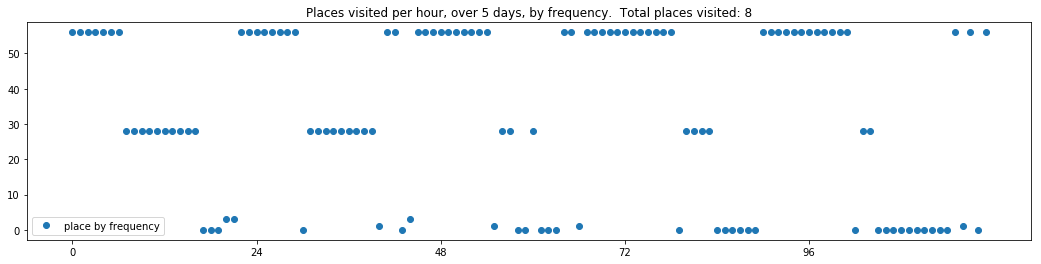

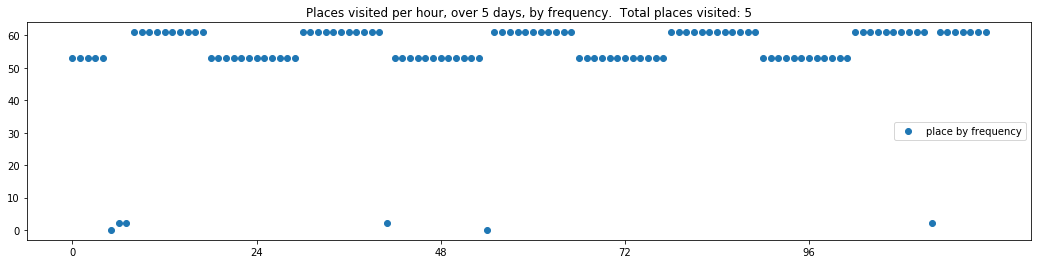

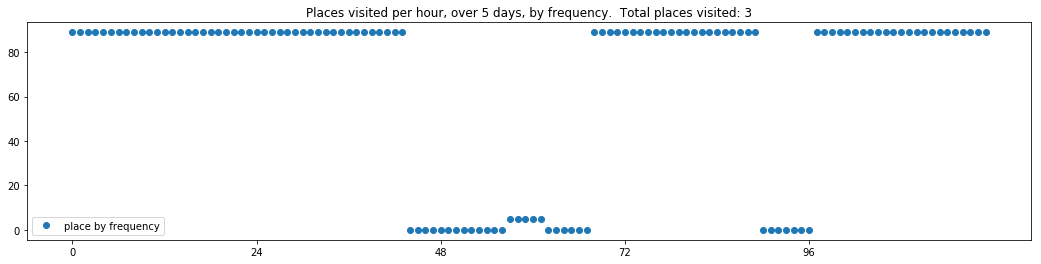

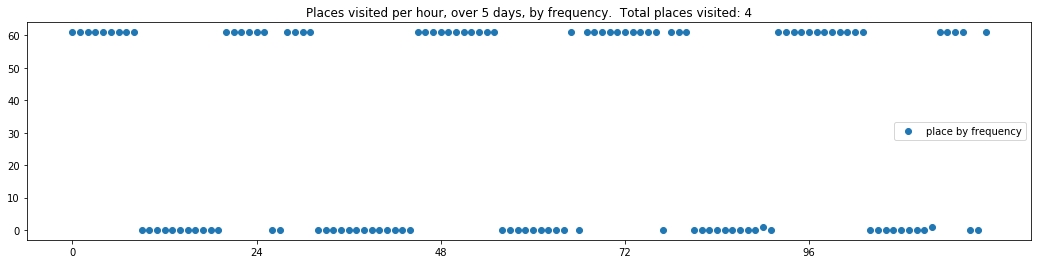

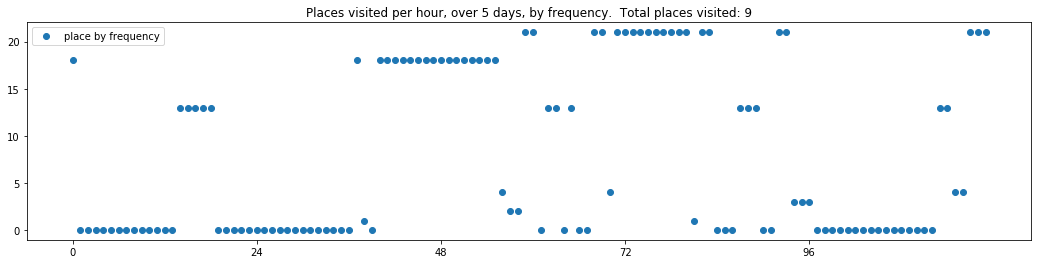

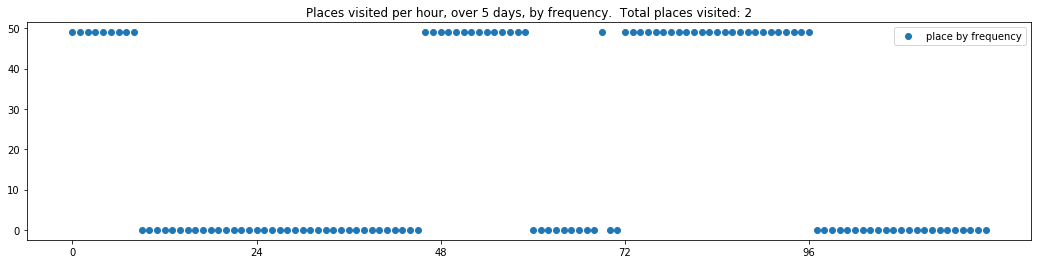

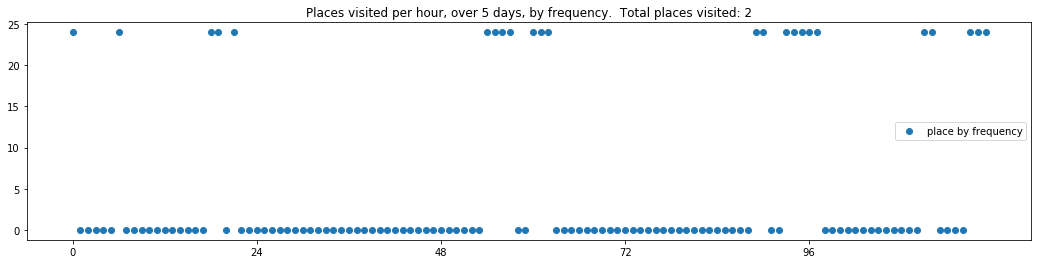

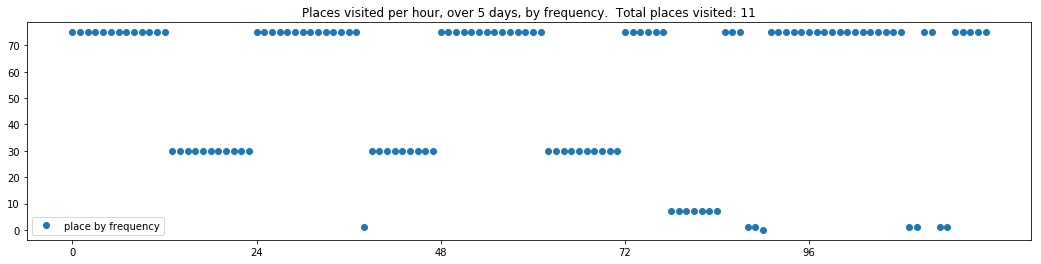

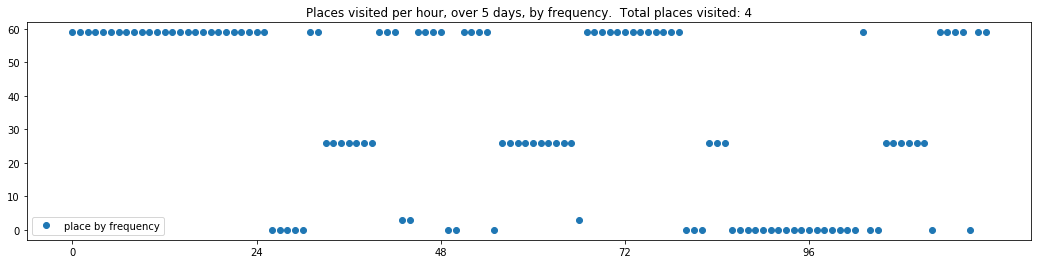

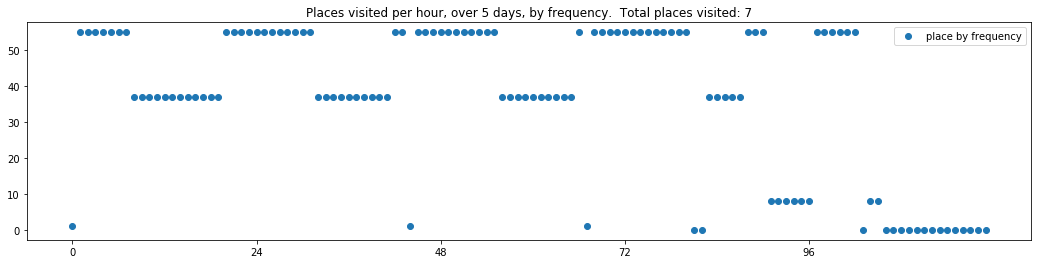

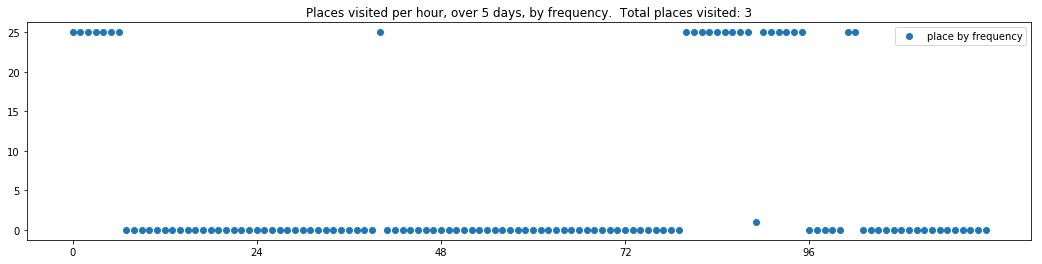

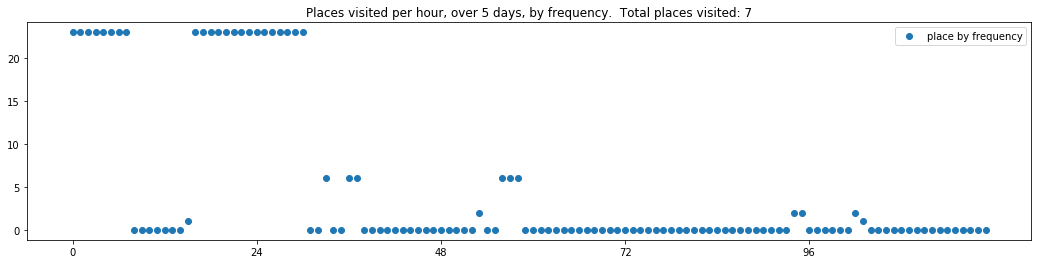

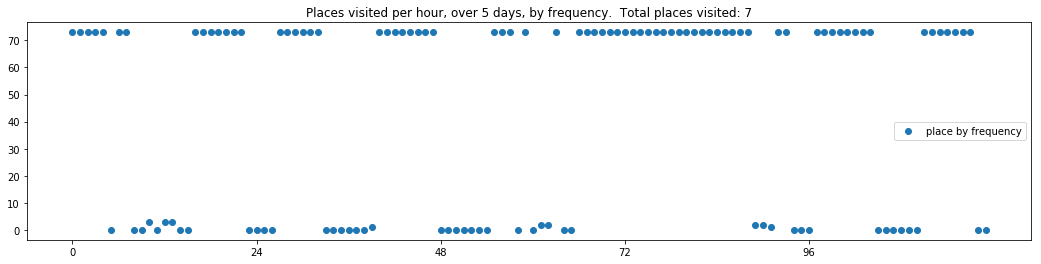

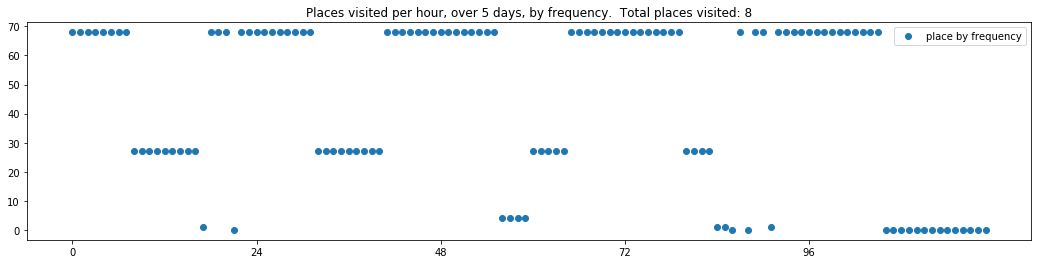

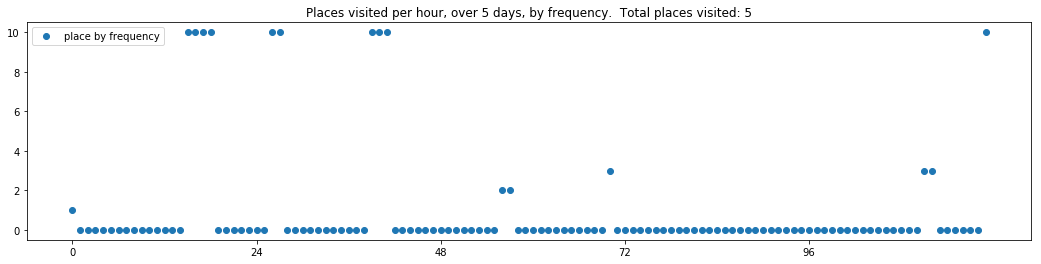

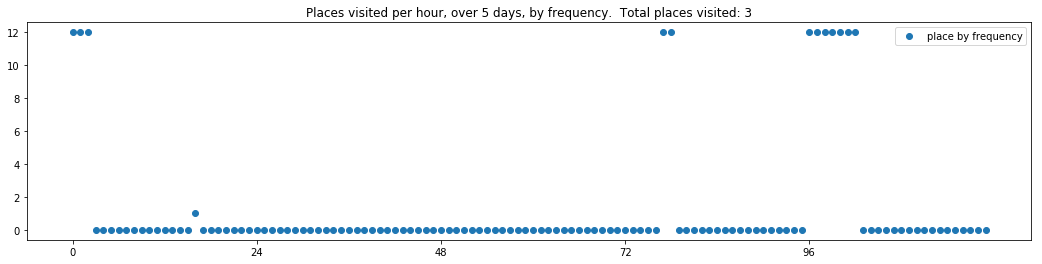

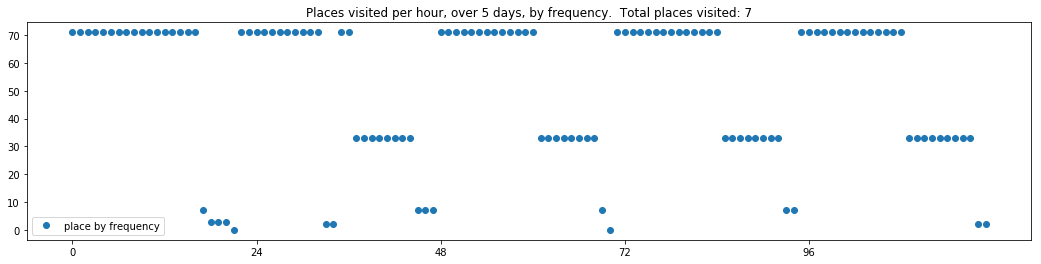

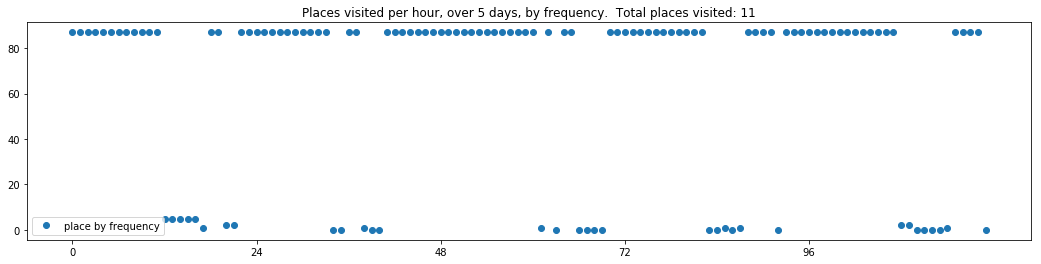

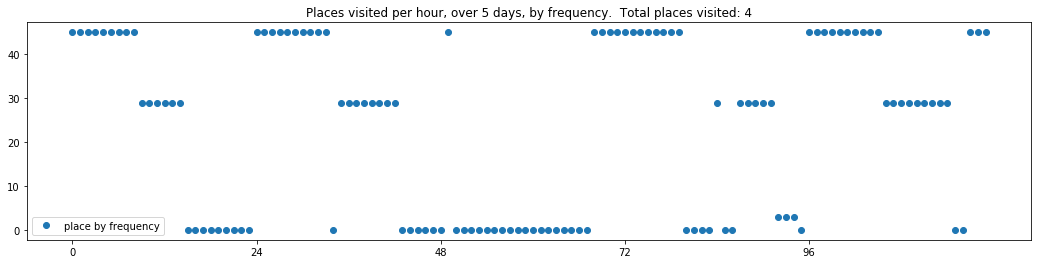

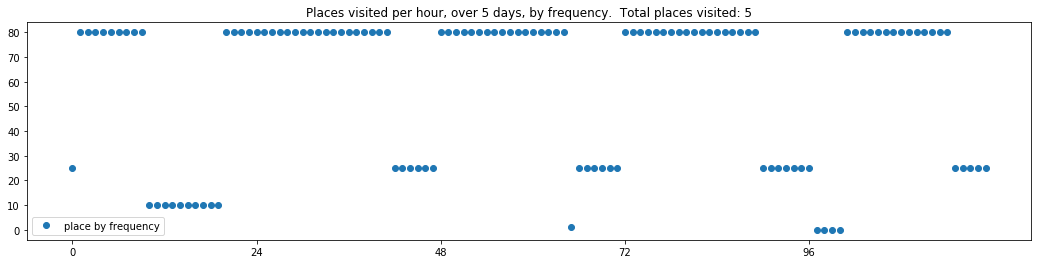

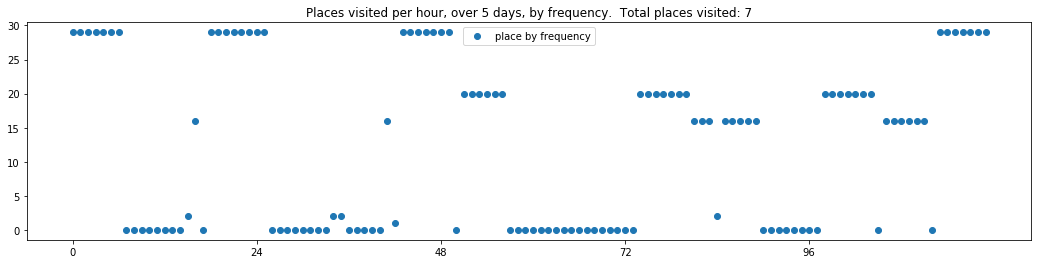

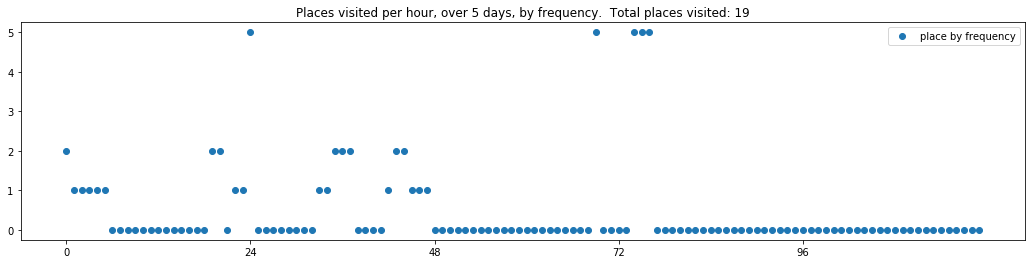

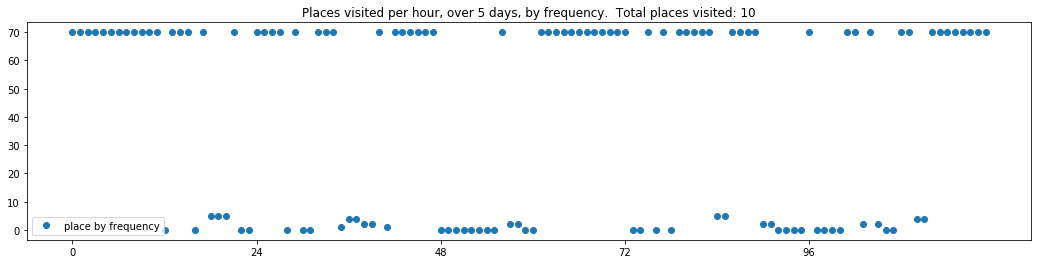

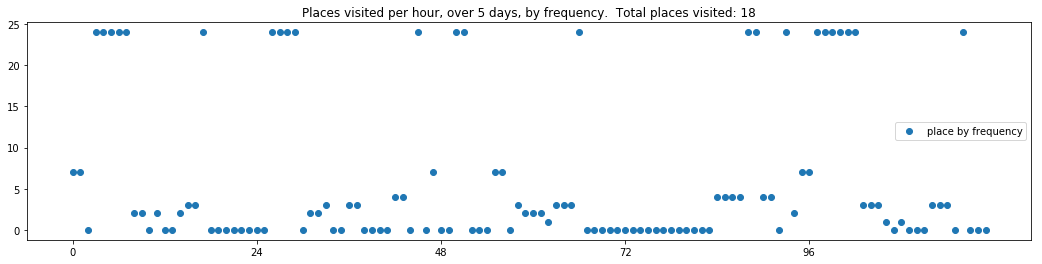

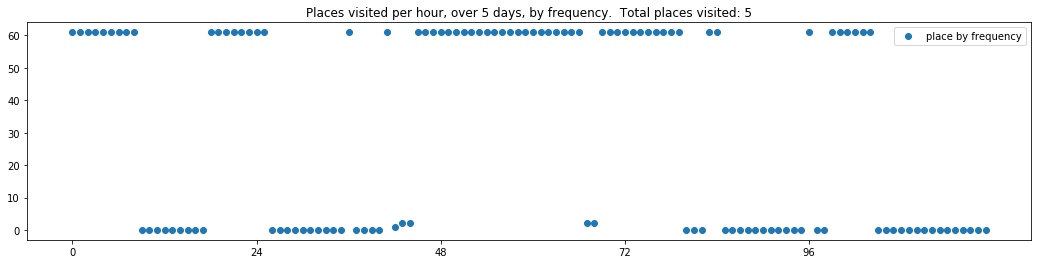

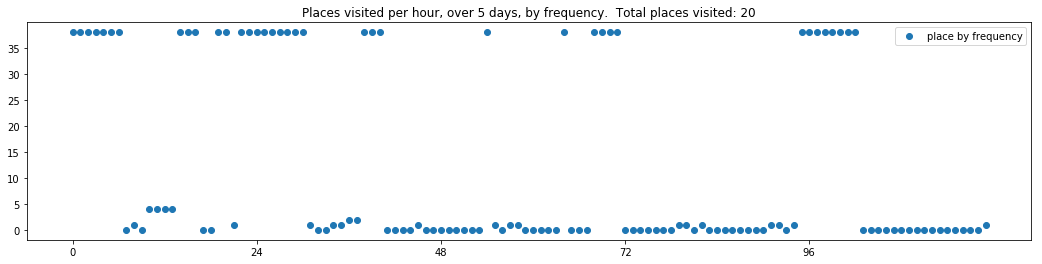

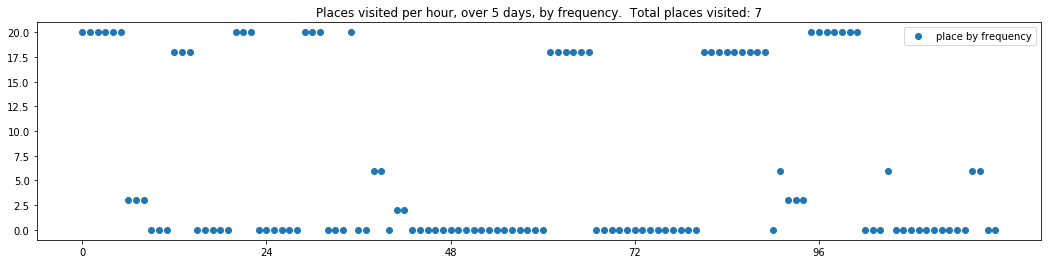

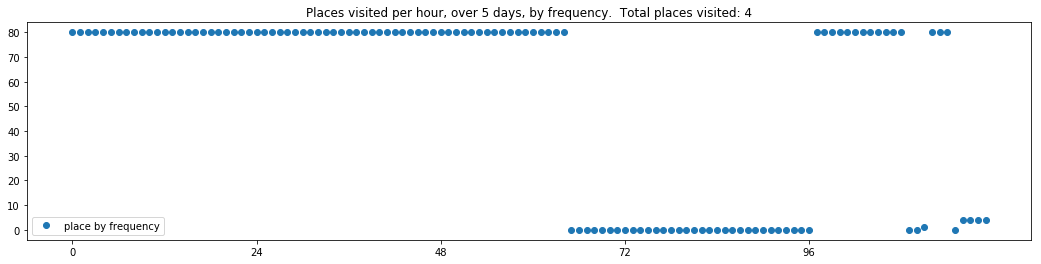

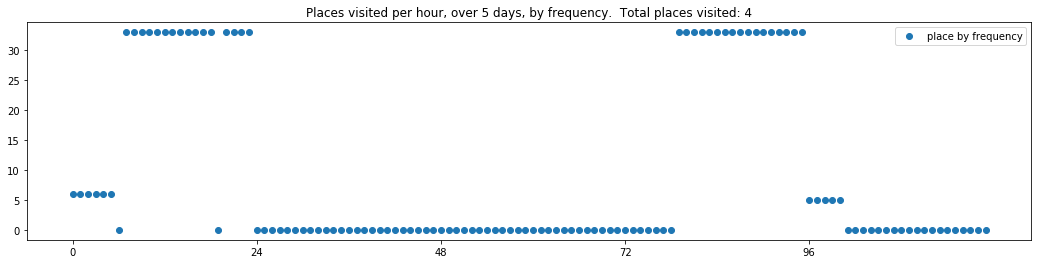

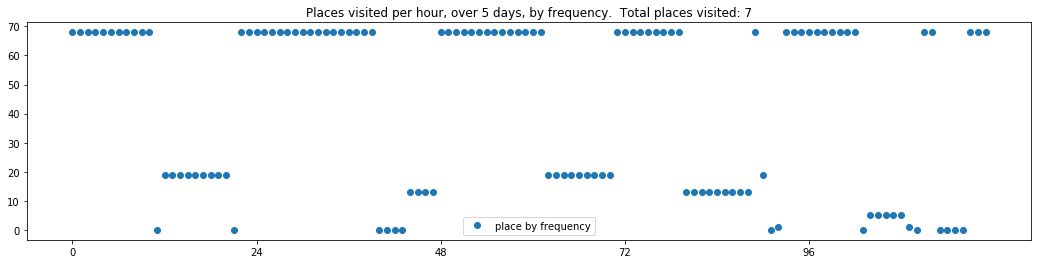

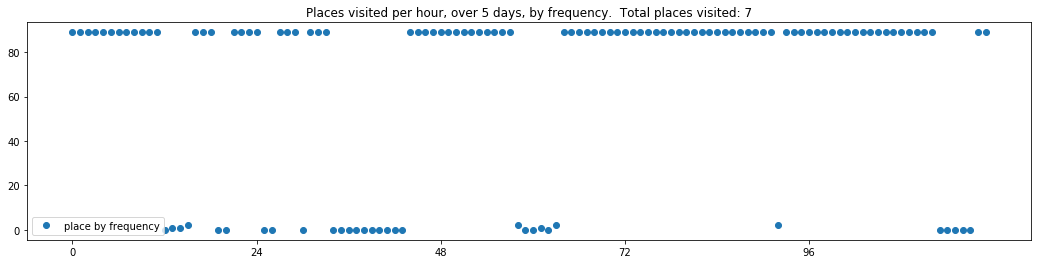

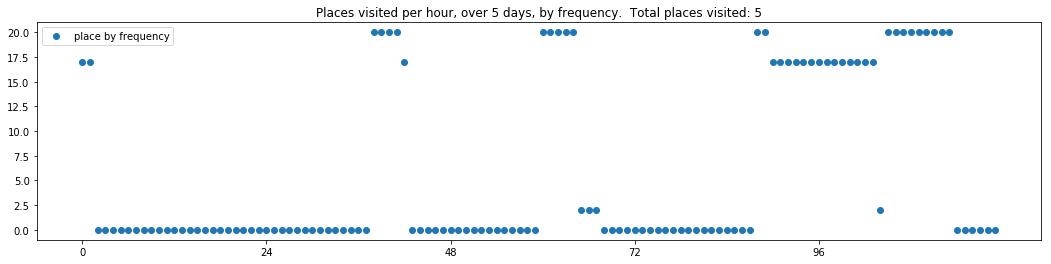

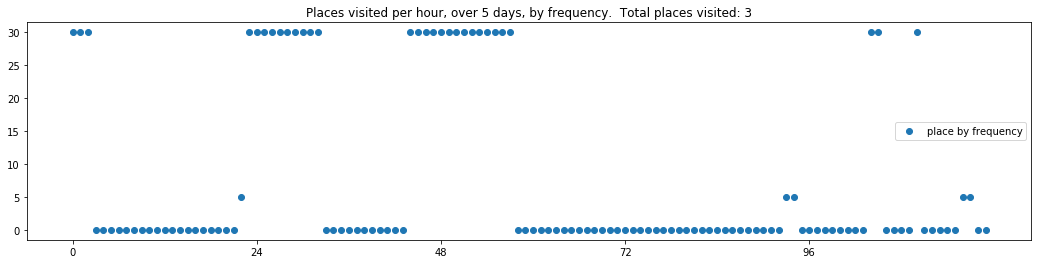

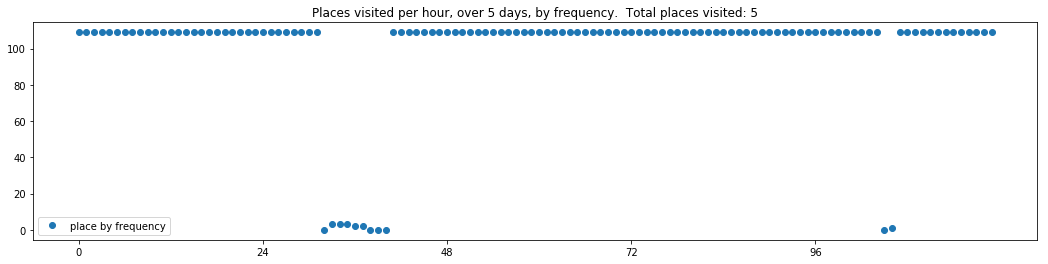

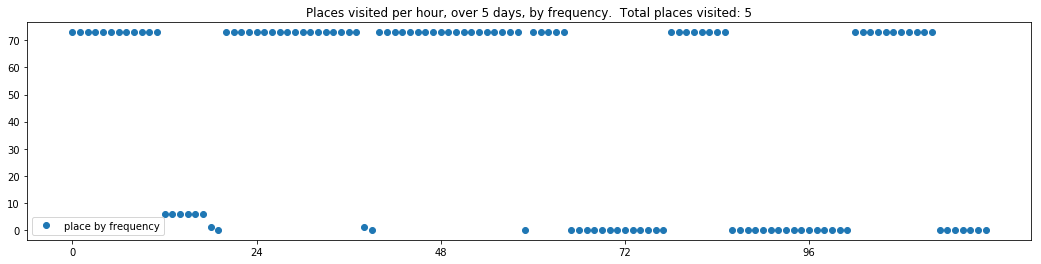

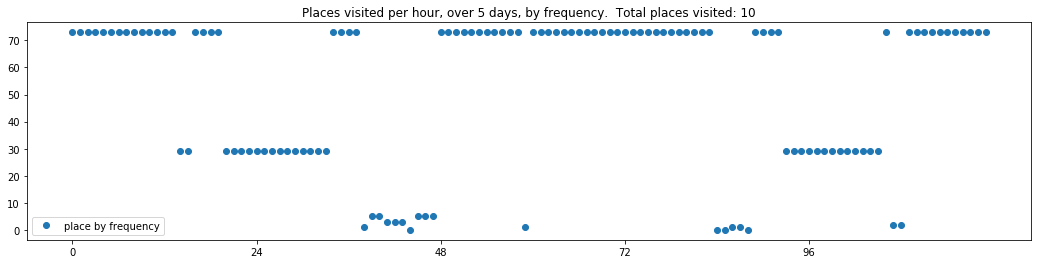

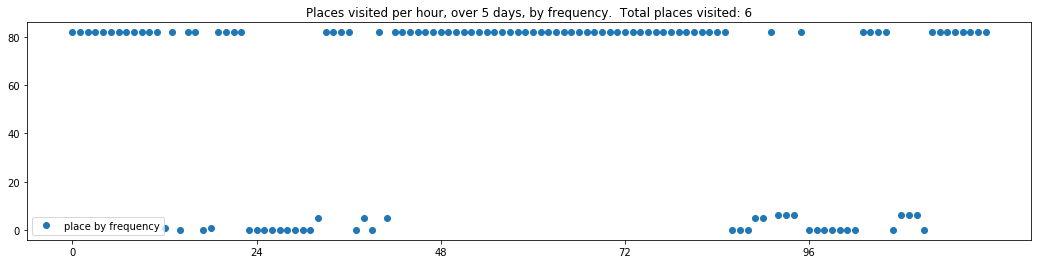

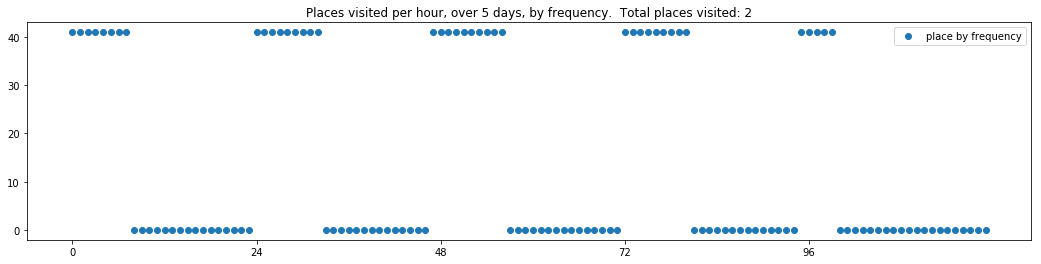

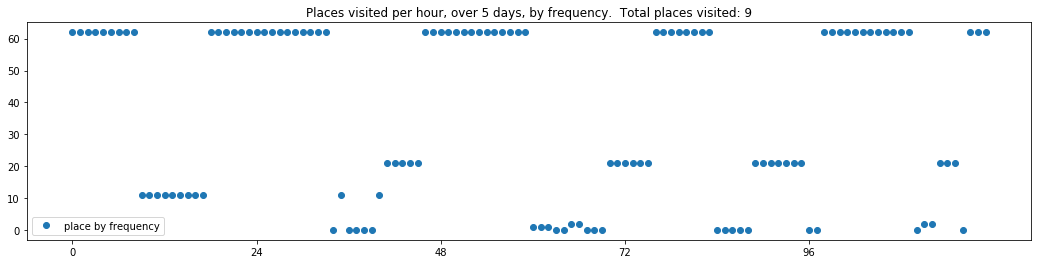

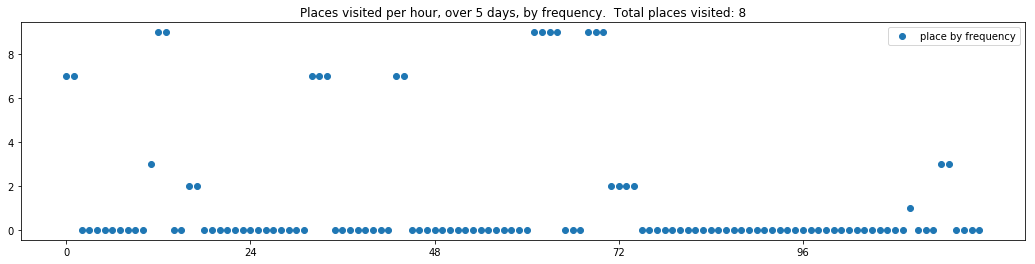

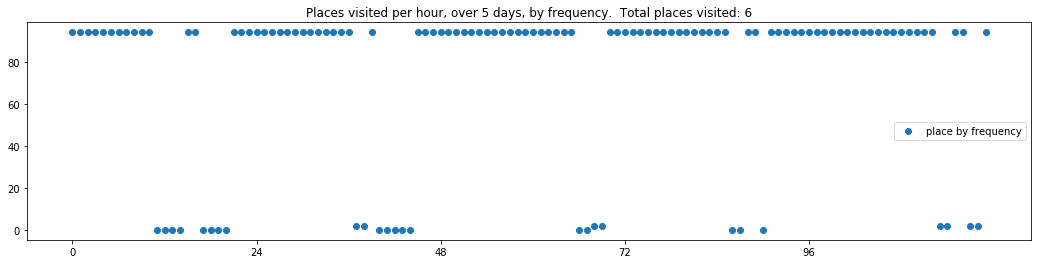

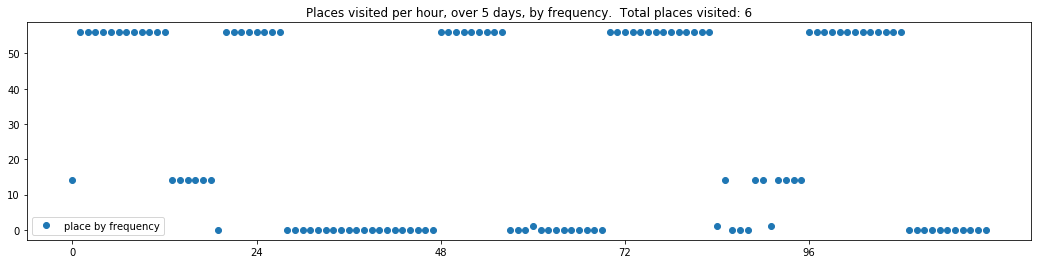

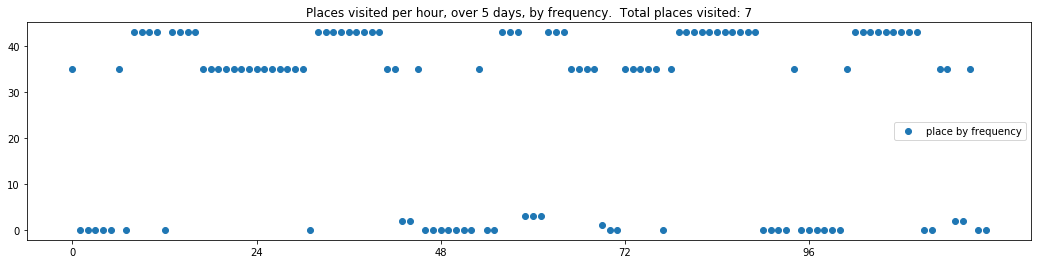

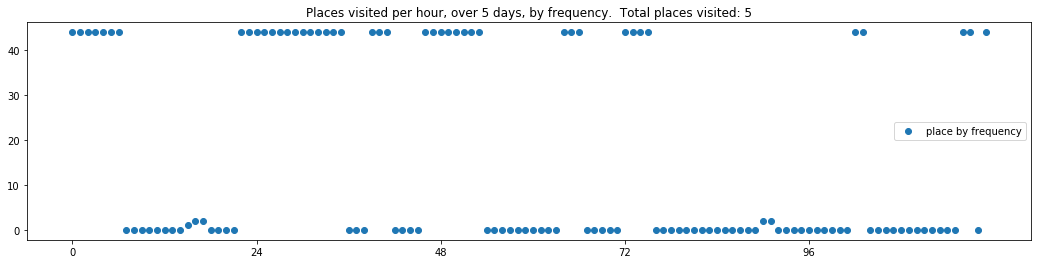

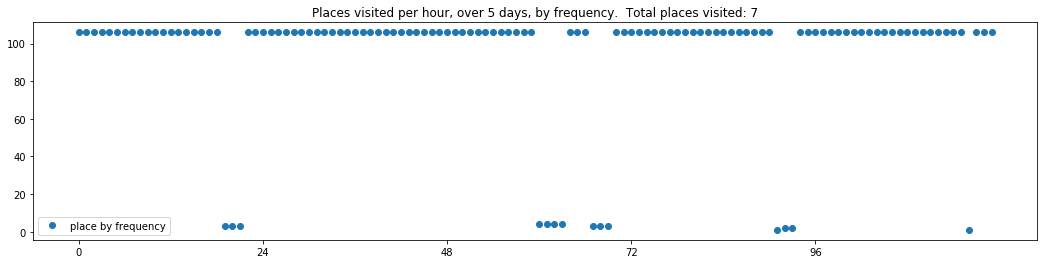

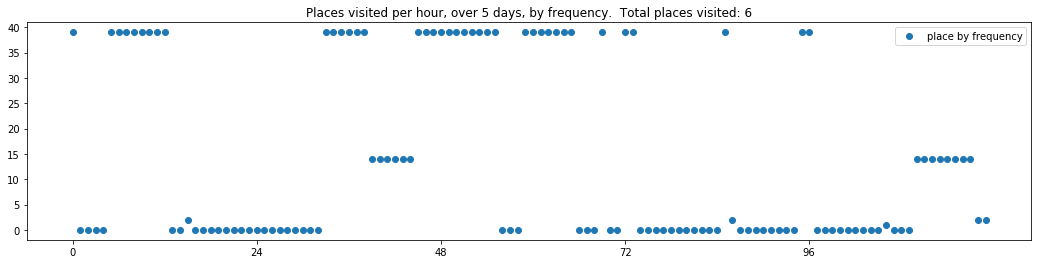

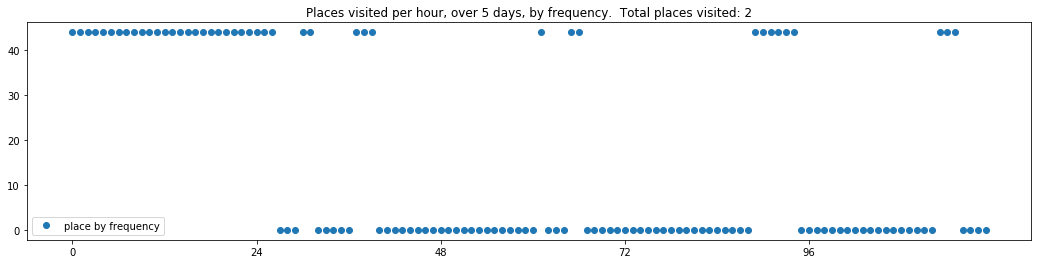

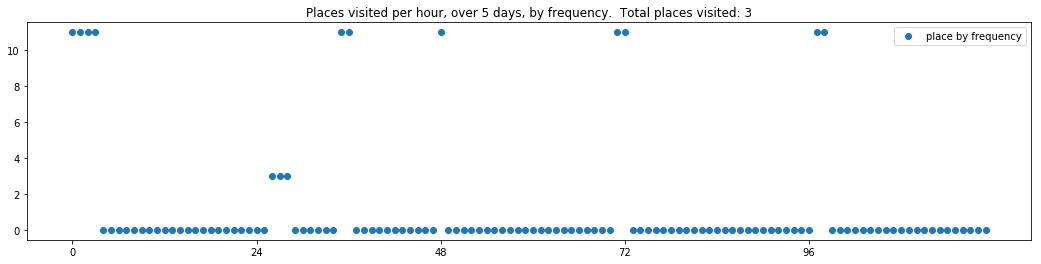

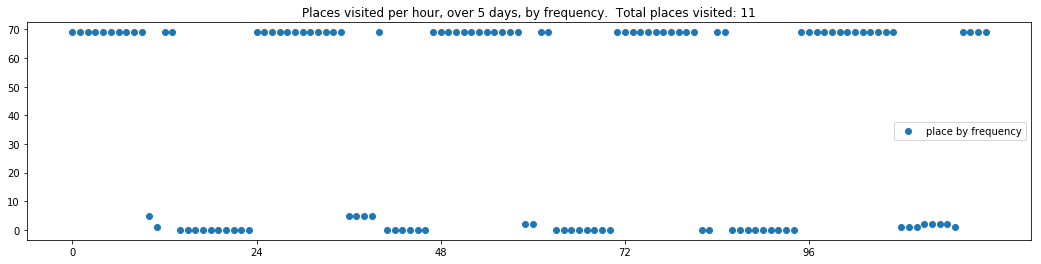

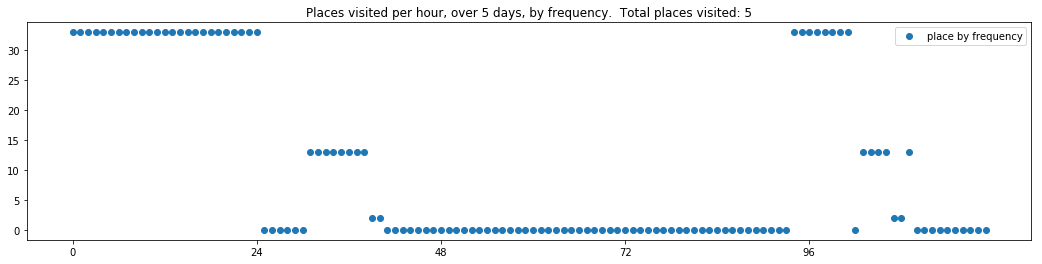

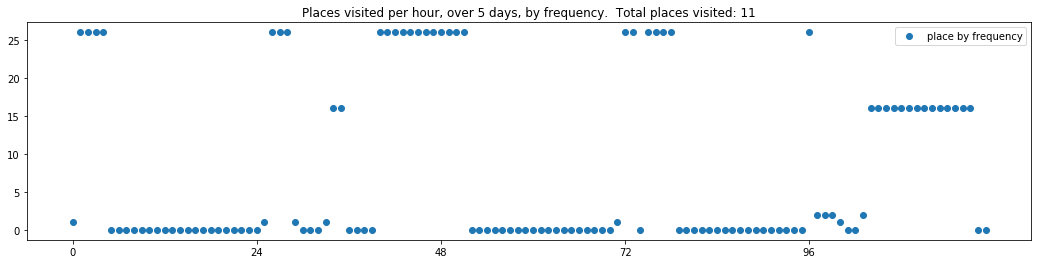

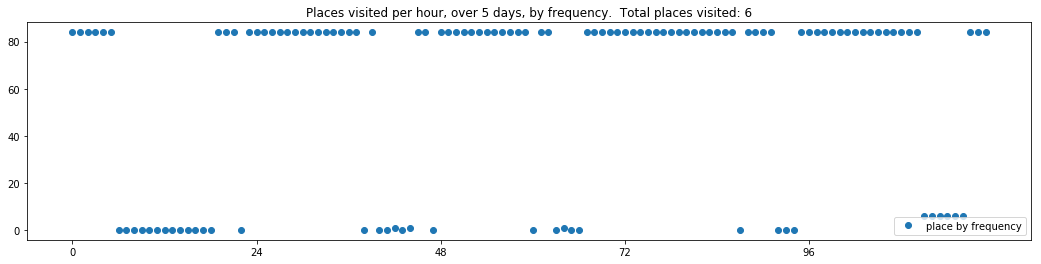

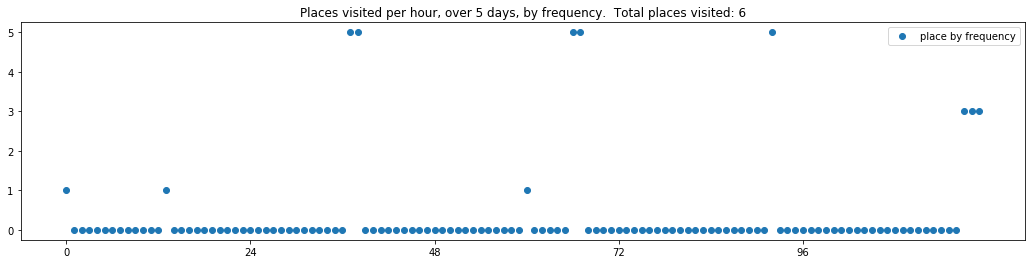

In [34]:
for v in relabeled_prefixed_dwell_vectors_subset:
    plot_trajectory_vector_frequencies(v)
